# IMPORTS

In [1]:
import pandas as pd 
import os
import json
import numpy as np

# from spacy.matcher import Matcher 
# from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm
import re
from nltk.tokenize import sent_tokenize

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoModelForCausalLM
import math
import torch
import IPython
from pyvis.network import Network
import wikipedia

import pickle
import textwrap

from joblib import Parallel, delayed
import multiprocessing
from collections import Counter, defaultdict

from functools import partial
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from fuzzywuzzy import fuzz


e:\Downloads\WeLearn\9th Sem\nineSemEnv\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# OFFLINE WIKI CLASS

In [2]:
from WikiDump_Search.wikiDumpSearch import offline_Wiki


# KB CLASS

In [3]:
class KB():
    def __init__(self):
        self.entities = {} # { entity_title: {...} }
        self.relations = [] # [ head: entity_title, type: ..., tail: entity_title,
          # meta: { article_url: { spans: [...] } } ]
        self.sources = {} # { article_url: {...} }

    def merge_with_kb(self, kb2):
        for r in kb2.relations:
            article_url = list(r["meta"].keys())[0]
            source_data = kb2.sources[article_url]
            self.add_relation(r, source_data["article_title"],
                              source_data["article_publish_date"])

    def are_relations_equal(self, r1, r2):
        return all(r1[attr] == r2[attr] for attr in ["head", "type", "tail"])

    def exists_relation(self, r1):
        return any(self.are_relations_equal(r1, r2) for r2 in self.relations)

    def merge_relations(self, r2):
        r1 = [r for r in self.relations
              if self.are_relations_equal(r2, r)][0]

        # if different article
        article_url = list(r2["meta"].keys())[0]
        if article_url not in r1["meta"]:
            r1["meta"][article_url] = r2["meta"][article_url]

        # if existing article
        
        else:
            spans_to_add = [span for span in r2["meta"][article_url]["spans"]
                            if span not in r1["meta"][article_url]["spans"]]
            r1["meta"][article_url]["spans"] += spans_to_add
            

    def get_wikipedia_data(self, candidate_entity, useWiki = True, offline_wiki = None, verbose = False):
        # print("\n\n--- offline", offline_Wiki)
        entity_data = None
        stop_words = set(stopwords.words('english'))
        if len(candidate_entity.split()) > 4:
            word_tokens = word_tokenize(candidate_entity)
            candidate_entity = " ".join([w for w in word_tokens if not w.lower() in stop_words])

        try:
            if offline_wiki:
                if verbose:
                    print(f"Finding {candidate_entity} in offline Wiki")
                _entity_data = offline_wiki.word_match(candidate_entity, verbose = verbose)
                
                if verbose:
                    print(f"Got {_entity_data} after word_match from offline Wiki")

                if "REDIRECT" in _entity_data["summary"][:10]:
                    entity_data = _entity_data
                else:                    
                    ratioo = fuzz.ratio(candidate_entity, _entity_data['title'])
                    if verbose:
                        print(f"Fuzz ration : {ratioo}")
                    if ratioo > 50 :
                        entity_data = _entity_data
                        if verbose:
                            print(f"Got {entity_data} from offline wiki with similarity ration = {ratioo}.")
            
            if useWiki and not entity_data:
                if verbose:
                    print(f"Finding {candidate_entity} in online Wiki")
                page = wikipedia.page(candidate_entity, auto_suggest=False)
                entity_data = {
                    "title": page.title,
                    "url": page.url,
                    "summary": page.summary
                }
            
            return entity_data
        except:
            return None

    def add_entity(self, e):
        self.entities[e["title"]] = {k:v for k,v in e.items() if k != "title"}

    def add_relation(self, r, article_title, article_publish_date, 
                     useWiki = True, offlineWiki = None, verbose = False):
        # check on wikipedia
        candidate_entities = [r["head"], r["tail"]]
        if verbose:
            print(f"Candidate entities : {candidate_entities}")
            
        # entities = [self.get_wikipedia_data(ent) for ent in candidate_entities]
        
        # TRY 2
        entities = []
        if useWiki:
            entities = Parallel(n_jobs=N_JOB_COUNT)(delayed(self.get_wikipedia_data)(ent, useWiki, offlineWiki, verbose=verbose) for ent in candidate_entities)
            # entities = [self.get_wikipedia_data(ent, useWiki, offlineWiki) for ent in candidate_entities]

        else:
            entities = [{"title": ent,
                         "url": "",
                         "summary": ""
                        } for ent in candidate_entities]

        # if one entity does not exist, stop
        if any(ent is None for ent in entities):
            return

        # manage new entities
        for e in entities:
            self.add_entity(e)

        # rename relation entities with their wikipedia titles
        r["head"] = entities[0]["title"]
        r["tail"] = entities[1]["title"]

        # add source if not in kb
        article_url = list(r["meta"].keys())[0]
        if article_url not in self.sources:
            self.sources[article_url] = {
                "article_title": article_title,
                "article_publish_date": article_publish_date
            }

        # manage new relation
        if not self.exists_relation(r):
            self.relations.append(r)
        else:
            self.merge_relations(r)

    def print(self):
        print("Entities:")
        for e in self.entities.items():
            print(f"  {e}")
        print("Relations:")
        for r in self.relations:
            print(f"  {r}")
        print("Sources:")
        for s in self.sources.items():
            print(f"  {s}")

# FOR GPU

In [4]:
def get_cpu_count():
    c = multiprocessing.cpu_count()
    return c 

def check_gpu():
    for i in range(torch.cuda.device_count()):
        device_name = f'cuda:{i}'
        print(f'{i} device name:{torch.cuda.get_device_name(torch.device(device_name))}')

def get_gpu():
    return [f'cuda:{i}' for i in range(torch.cuda.device_count())]

print(check_gpu())

print(get_gpu())

print(get_cpu_count())

N_JOB_COUNT = get_cpu_count()//2
N_JOB_COUNT = 1 # PARALLEL CAUSES ERROR, SO KEEPING IT 1
# N_JOB_COUNT = 4

0 device name:NVIDIA GeForce RTX 3060 Laptop GPU
None
['cuda:0']
16


# HELPER FUNCTION

In [5]:
def loadJSON(filepathh):
    _dataa = {} 
    if os.path.exists(filepathh):
        with open(filepathh, "r", encoding="utf-8") as _f:
            _dataa = json.load(_f)
    else:
        print(f"{filepathh} does not exists...\n") 
    return _dataa 

def loadTXT(filepathh):
    _dataa = ""
    if os.path.exists(filepathh):
        with open(filepathh, "r", encoding="utf-8") as _f:
            _dataa = _f.read()
    else:
        print(f"{filepathh} does not exists...\n") 
    return _dataa 

def loadFILE(filepathh = ""):
    if os.path.exists(filepathh):
        if filepathh.endswith(".txt"):
            return loadTXT(filepathh)
        elif filepathh.endswith(".json"):
            return loadJSON(filepathh)
        else:
            print("\n- Invalid File format 😐 !!!\n")
            return None
    else:
        print(f"{filepathh} does not exists...\n") 

def remove_garbage(text):
    # Remove garbage Unicode characters
    cleaned_text = text.encode().decode('unicode-escape')
    # Remove any remaining non-printable characters
    cleaned_text = re.sub(r'[^\x20-\x7E]', '', cleaned_text)
    return cleaned_text

def clean_sentence(sentence):
    # Remove extra white spaces
    cleaned_sentence = re.sub(r'\s+', ' ', sentence)
    # Remove unwanted characters except alphabets, numbers, punctuation marks, '@', '-', and '_'
    cleaned_sentence = re.sub(r'[^a-zA-Z0-9@#\-_.,?!\'" ]', '', cleaned_sentence)
    # Remove words containing '#' and 'pic.twitter.com'
    cleaned_sentence = ' '.join(word if '#' not in word and 'pic.twitter.com' not in word else ' ' for word in cleaned_sentence.split() )
    return cleaned_sentence.strip()

def clean_document(document):
    document = remove_garbage(document)
    # Tokenize the document into sentences
    sentences = sent_tokenize(document)
    # Clean each sentence
    cleaned_sentences = [clean_sentence(sentence) for sentence in sentences]
    return cleaned_sentences

In [6]:
def save_network_html(kb, filename="network.html", 
                      verbose = False, 
                      physics = False,
                      show = False):

    if not os.path.exists(filename):
        with open(filename, 'w') as _file:
            _file.write("")

    # create network
    G = nx.Graph()
    net = Network(directed=True, 
                  notebook=True,
                  width="1000px", 
                  height="1000px",
                #   bgcolor="#eeeeee"
                )
    if verbose:
        print("Network initialized")

    # nodes
    color_entity = "#00FF00"
    if verbose:
        print(f"there are {len(kb.entities)} entities in KB")
    for e in kb.entities:
        G.add_node(e)
        net.add_node(e, label=e, shape="dot", color=color_entity)
        # net.add_node(e, label=e, physics = physics, shape="dot", color=color_entity)
    
    # edges
    if verbose:
        print(f"there are {len(kb.relations)} relations in KB")
    
    # for r in kb.relations:
    #     G.add_edge(r['head'], r["tail"], )
    #     # net.add_edge(r["head"], r["tail"], title=r["type"], label=r["type"])
    labels = {}
    for r in kb.relations:
        G.add_edge(r['head'], r["tail"])
        labels[(r["head"], r["tail"])] = r["type"]
        net.add_edge(r["head"], r["tail"], title=r["type"], label=r["type"])

    scale=10 # Scaling the size of the nodes by 10*degree
    d = dict(G.degree)

    pos = nx.spring_layout(G)
    #Updating dict
    d.update((x, scale*y) for x, y in d.items())

    #Setting up size attribute
    nx.set_node_attributes(G,d,'size')
    nx.set_edge_attributes(G,labels, 'labels')
    # nx.draw_networkx_edge_labels(
    #                             G, pos,
    #                             edge_labels=labels,
    #                             # font_color='red'
    #                             )
    if verbose:
        print(f"Trying to make graph")

    # net.from_nx(G)   
    
    # save network
    if physics:
        net.repulsion(
            node_distance=200,
            central_gravity=0.3,
            spring_length=200,
            spring_strength=0.05,
            damping=0.09
        )

    net.set_edge_smooth('dynamic')

    if verbose:
        print(f"Trying to show graph")

    net.show(filename)

def save_kb(kb, filename, verbose = False):
    if verbose:
        print(f"there are {len(kb.entities)} entities in KB")
        print(f"there are {len(kb.relations)} relations in KB")

    with open(filename, "wb") as f:
        pickle.dump(kb, f)

def load_kb(filename):
    res = None
    with open(filename, "rb") as f:
        res = pickle.load(f)
    return res


# DOING NER

In [7]:
def extract_relations_from_model_output(text):
    relations = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    text_replaced = text.replace("<s>", "").replace("<pad>", "").replace("</s>", "")
    for token in text_replaced.split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        relations.append({
            'head': subject.strip(),
            'type': relation.strip(),
            'tail': object_.strip()
        })
    return relations

In [8]:
def split_docs(text, 
               max_text_count = 1000,
               verbose = False):
    
    sentences = sent_tokenize(text)
    chunks = []
    chunk = ""
    len_sentence = 0
    chunk_len = 0
    for sentence in sentences:
      len_sentence = len(sentence.strip().split())
      if chunk_len+len_sentence < max_text_count:
         chunk += sentence+" "
         chunk_len += len_sentence
         continue
      chunk_len = len_sentence
      chunks.append(chunk)
      chunk = sentence
      
      # chunk = textwrap.wrap(sentence, max_text_count)
    if verbose:
      print(len(chunks))
    return chunks

def _from_text_to_kb(text, article_url, kb = None,
                    useGPU=0, 
                    span_length=128, 
                    article_title=None,
                    article_publish_date=None, 
                    verbose=False,
                    useWiki=True,
                    offline_Wiki = None):
    
    # tokenize whole text
    # print(text)
    # input()
    with torch.no_grad():
        inputs = tokenizer([text], 
                        max_length = 1000,
                        #    max_length=512,
                        padding=True,  
                        truncation=True, 
                        return_tensors="pt")

        # compute span boundaries
        # print(inputs.values())
        num_tokens = len(inputs["input_ids"][0])
        if verbose:
            print(f"Input has {num_tokens} tokens")
        num_spans = math.ceil(num_tokens / span_length)
        
        if verbose:
            print(f"Input has {num_spans} spans")
        overlap = math.ceil((num_spans * span_length - num_tokens) / 
                            max(num_spans - 1, 1))
        
        # input()
        spans_boundaries = []
        start = 0
        for i in range(num_spans):
            spans_boundaries.append([start + span_length * i,
                                    start + span_length * (i + 1)])
            start -= overlap
        if verbose:
            print(f"Span boundaries are {spans_boundaries}")

        # transform input with spans
        tensor_ids = [inputs["input_ids"][0][boundary[0]:boundary[1]]
                    for boundary in spans_boundaries]
        tensor_masks = [inputs["attention_mask"][0][boundary[0]:boundary[1]]
                        for boundary in spans_boundaries]
        inputs = {
            "input_ids": torch.stack(tensor_ids),
            "attention_mask": torch.stack(tensor_masks)
        }
        
        # generate relations
        num_return_sequences = 3
        gen_kwargs = {
            "max_length": 256,
            "length_penalty": 0,
            "num_beams": 3,
            "num_return_sequences": num_return_sequences
        }

        generated_tokens = model.generate(
                                            inputs["input_ids"].to(model.device),
                                            attention_mask=inputs["attention_mask"].to(model.device),
                                            **gen_kwargs,
                                            )

        # decode relations
        decoded_preds = tokenizer.batch_decode(generated_tokens,
                                            skip_special_tokens=False)

        # create kb
        if not kb:
            kb = KB()

        i = 0
        # for sentence_pred in tqdm(decoded_preds, leave=False):
        _relations = Parallel(n_jobs=N_JOB_COUNT)(delayed(extract_relations_from_model_output)(sentence_pred) for sentence_pred in decoded_preds)

        for sentence_pred in decoded_preds:
            current_span_index = i // num_return_sequences
            # relations = extract_relations_from_model_output(sentence_pred)
            relations = _relations[i]

            if verbose:
                print(f"{i}. extraction of relations done, it has {len(relations)} relations", end="\r")
                
            for relation in relations:
                relation["meta"] = {
                    article_url: {
                        "spans": [spans_boundaries[current_span_index]]
                    }
                }
                kb.add_relation(relation, 
                                article_title,
                                article_publish_date, 
                                useWiki=useWiki,
                                offlineWiki=offline_Wiki,
                                verbose=verbose)
            i += 1

    return kb

def from_text_to_kb(text, article_url, kb = None,
                    useGPU=0, 
                    span_length=128, 
                    article_title=None,
                    article_publish_date=None, 
                    verbose=False,
                    max_token = 1000,
                    max_doc_text = 1000,
                    useWiki = True,
                    offlineWiki = None):
    # with torch.no_grad():
    #     # tokenize whole text
    #     # inputs = tokenizer([text], return_tensors="pt")
    #     # num_tokens = len(inputs["input_ids"][0])

    input_words = text.split()
    num_tokens = len(input_words)

    if verbose:
        # print(f"Input has {num_tokens} tokens")
        print(f"Input has {num_tokens} words")

    if not kb:
        kb = KB()
    
    _kb = kb 

    _offlineWiki = offlineWiki

    # compute span boundaries
    # num_tokens = len(inputs["input_ids"][0])
    if num_tokens > max_token:
        if verbose:
            print("input len > token size, splitting doc in smaller chunks")
        text = split_docs(text, max_text_count=max_doc_text)
    
    if type(text) == str:
        text = [text]
    
    # for _text in tqdm(text, leave=False):
    for _text in text: 
        # print(_text)
        # print(_text[0])
        # input()
        _kb = _from_text_to_kb(_text, article_url, 
                            useGPU=useGPU, 
                            span_length=span_length, 
                            article_title=article_title,
                            article_publish_date=article_publish_date, 
                            verbose=verbose,
                            kb=_kb,
                            useWiki=useWiki,
                            offline_Wiki=_offlineWiki)
    return _kb
                

In [9]:
def save_network_html(kb, filename="network.html", 
                      verbose = False, 
                      physics = False,
                      show = False):

    if not os.path.exists(filename):
        with open(filename, 'w') as _file:
            _file.write("")

    # create network
    G = nx.Graph()
    net = Network(directed=True, 
                  notebook=True,
                  width="1000px", 
                  height="1000px",
                #   bgcolor="#eeeeee"
                )
    if verbose:
        print("Network initialized")

    # nodes
    color_entity = "#00FF00"
    if verbose:
        print(f"there are {len(kb.entities)} entities in KB")
    for e in kb.entities:
        G.add_node(e)
        net.add_node(e, label=e, shape="dot", color=color_entity)
        # net.add_node(e, label=e, physics = physics, shape="dot", color=color_entity)
    
    # edges
    if verbose:
        print(f"there are {len(kb.relations)} relations in KB")
    
    # for r in kb.relations:
    #     G.add_edge(r['head'], r["tail"], )
    #     # net.add_edge(r["head"], r["tail"], title=r["type"], label=r["type"])
    labels = {}
    for r in kb.relations:
        G.add_edge(r['head'], r["tail"])
        labels[(r["head"], r["tail"])] = r["type"]
        net.add_edge(r["head"], r["tail"], title=r["type"], label=r["type"])

    scale=10 # Scaling the size of the nodes by 10*degree
    d = dict(G.degree)

    pos = nx.spring_layout(G)
    #Updating dict
    d.update((x, scale*y) for x, y in d.items())

    #Setting up size attribute
    nx.set_node_attributes(G,d,'size')
    nx.set_edge_attributes(G,labels, 'labels')
    # nx.draw_networkx_edge_labels(
    #                             G, pos,
    #                             edge_labels=labels,
    #                             # font_color='red'
    #                             )
    if verbose:
        print(f"Trying to make graph")

    # net.from_nx(G)   
    
    # save network
    if physics:
        net.repulsion(
            node_distance=200,
            central_gravity=0.3,
            spring_length=200,
            spring_strength=0.05,
            damping=0.09
        )

    net.set_edge_smooth('dynamic')

    if verbose:
        print(f"Trying to show graph")

    net.show(filename)

# --- BREAK ---

# EXP

### LOAD MODEL

In [10]:
# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("Babelscape/rebel-large")
model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/rebel-large")

In [11]:
model.to(get_gpu()[0])


BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50272, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50272, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): La

### LOADING OFFLINE WIKI

In [12]:
WIKI_INDEX_FILE = "D://WikiDump/enwiki-20240220-pages-articles-multistream-index.txt/enwiki-20240220-pages-articles-multistream-index.txt"
WIKI_BZ2_FILE = "D://WikiDump/enwiki-20240220-pages-articles-multistream.xml.bz2"

INDEX_FOLDER = "./WikiDump_Search/indexes/"

In [13]:
offline_wikipedia = offline_Wiki(wiki_index_file=WIKI_INDEX_FILE,
                                wikiDump_bz2_file=WIKI_BZ2_FILE, verbose=True,
                                index_folder=INDEX_FOLDER)

In [14]:
# testing
print(offline_wikipedia.word_match("tigers", summaryOnly=False))
input()

test_words = ["sachin", "trump", "wedding", "white house", "modi", "apple", "windows 11"]
for test_word in test_words:
    print(offline_wikipedia.word_match(test_word))

{'title': 'Tigers', 'url': 'https://en.wikipedia.org/wiki/Tiger', 'summary': 'REDIRECT Tiger'}
{'title': 'Sachin', 'url': 'https://en.wikipedia.org/wiki/Sachin', 'summary': 'Sachin may refer to:\nSachin (given name), an Indian given name, including a list of people with the name\n* Sachin (actor) (born 1957), Indian actor and filmmaker\n* Sachin (boxer), Indian boxer\n* Sachin Tendulkar (born 1973), Indian cricketer\n'}
{'title': 'Trump', 'url': 'https://en.wikipedia.org/wiki/Trump', 'summary': 'Trump most commonly refers to:\nDonald Trump (born 1946), President of the United States from 2017 to 2021 \nTrump (card games), any playing card given an ad-hoc high rank\nTrump may also refer to:\n'}
{'title': 'Wedding', 'url': 'https://en.wikipedia.org/wiki/Wedding', 'summary': 'A wedding is a ceremony where two people are united in marriage. Wedding traditions and customs vary greatly between cultures, ethnic groups, races, religions, denominations, countries, social classes, and sexual ori

## LIAR

In [15]:
# FOR MAKING THE INTERMEDIATE DATA
store_folder = "./LIAR_data/"
statements_file = "./statements.json"

# FOR PROCESSING THE SIMILAR DATA
store_folder = "./"
statements_file = "./LIAR_similar_statements.json"


In [16]:
data_filepath = loadFILE(store_folder+statements_file) 

##### FOR FAKE DATA

In [17]:
countt = 0
for d_text in data_filepath["fake"]:
    print(" ".join(clean_document(d_text)))
    if countt > 5:
        break
    print()
    countt+=1

For the new state budget, "Floridians have sent us 3 billion less of their funding."

After President Barack Obamas health care law takes full effect, 100 percent of Americans will depend on some form of federal payment, some form of government benefit to help provide for them.

Says state Senate President Stephen Sweeney gave us the nations highest income tax rates, driving out jobs.

Nevada is still a state that is 80 percent white voters.

An audit of the last census found that over 370,000 people living in Texas were not counted, and our state lost an estimated 1 billion in federal funds as a result.

Says 97 cents of every dollar played represents over 500 million dollars that is returned to Oregonians every year to help support job creation, schools, state parks and watersheds.

Marco Rubio tried to insert 1.5 million for a rowing institute into the state budget.


In [18]:
texts = []
_data = data_filepath["fake"]
# articles_limit = 3542
articles_limit = int(input(f"enter number of docs to take (max : {len(_data)}): "))
print(f"taking {articles_limit} docs in KG")

countt = 0
for d_text in _data:
    _txt = " ".join(clean_document(d_text))
    # if len(_txt.split()) > 2000:
    #     continue
    texts.append(_txt)
    countt += 1
    if countt > articles_limit:
        break

taking 200 docs in KG


In [19]:
len(texts)

197

In [20]:
max_lenn = 1000
spann = 64

In [23]:
kb = KB()
max_lenn = 1000
for text in tqdm(texts):
    # print(len(text.split()))
    # print(text)
    kb = from_text_to_kb(text, "", kb = kb,
                         useGPU = 1, 
                         verbose = 0, 
                         span_length = spann, 
                         max_doc_text = max_lenn,
                         # useWiki = 0,                    # KEEPING IT 0, AS FOR NOW WE ONLY NEED THE POSSIBLE ENTITIES
                         useWiki = 1,                      # FOR PROCESSING THE SIMILAR DATA, WE KEEP IT 1, AS NOW WE WILL NORMALISE THE DATA WITH WIKIPEDIA
                         offlineWiki = offline_wikipedia)
    # kb.print()
    # input()

100%|██████████| 197/197 [06:02<00:00,  1.84s/it]


In [24]:
len(kb.entities), kb.print()

Entities:
  ('New State', {'url': 'https://en.wikipedia.org/wiki/Estado_Novo', 'summary': 'redirect Estado Novo'})
  ('Floridians', {'url': 'https://en.wikipedia.org/wiki/Floridian', 'summary': 'REDIRECT Floridian'})
  ('State General Budget', {'url': 'https://en.wikipedia.org/wiki/General_State_Budget_(Spain)', 'summary': 'REDIRECT General State Budget (Spain)'})
  ('Florida', {'url': 'https://en.wikipedia.org/wiki/Florida', 'summary': "Florida is a state in the Southeastern region of the United States. It borders the Gulf of Mexico to the west, Alabama to the northwest, Georgia to the north, the Bahamas and Atlantic Ocean to the east; and the Straits of Florida and Cuba to the south. It is the only state that borders both the Gulf of Mexico and the Atlantic Ocean. With a population over 21 million, it is the third-most populous state in the nation and ranks eighth in population density as of 2020. It spans , ranking 22nd in area among the 50 states. The Miami metropolitan area, ancho

(263, None)

In [25]:
# filename = f"LIAR_fake_entites_intermediate_RAW_{articles_limit}.html" # FOR STORING INTERNEDIIATE DATA
filename = f"LIAR_similar_fake_entites_{articles_limit}.html" # FOR STORING THE SIMILAR DATA

save_network_html(kb, filename=filename, verbose=True) # SAVE THE KG FOR SIMILAR DATA
save_kb(kb, os.path.basename(filename)[:-5]  + ".p")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
Network initialized
there are 263 entities in KB
there are 350 relations in KB
Trying to make graph
Trying to show graph


##### FOR REAL DATA 

In [26]:
texts = []
_data = data_filepath["real"]
# articles_limit = 4505
articles_limit = int(input(f"enter number of docs to take (max : {len(_data)}): "))
print(f"taking {articles_limit} docs in KG")

countt = 0
for d_text in _data:
    _txt = " ".join(clean_document(d_text))
    # if len(_txt.split()) > 2000:
    #     continue
    texts.append(_txt)
    countt += 1
    if countt > articles_limit:
        break

taking 330 docs in KG


In [27]:
len(texts)

330

In [28]:
kb = KB()
max_lenn = 1000
for text in tqdm(texts):
    # print(len(text.split()))
    # print(text)
    kb = from_text_to_kb(text, "", kb = kb,
                         useGPU = 1, 
                         verbose = 0, 
                         span_length = spann, 
                         max_doc_text = max_lenn,
                         # useWiki = 0,                    # KEEPING IT 0, AS FOR NOW WE ONLY NEED THE POSSIBLE ENTITIES
                         useWiki = 1,                      # FOR PROCESSING THE SIMILAR DATA, WE KEEP IT 1, AS NOW WE WILL NORMALISE THE DATA WITH WIKIPEDIA
                         offlineWiki = offline_wikipedia)


  8%|▊         | 28/330 [00:57<14:36,  2.90s/it]e:\Downloads\WeLearn\9th Sem\nineSemEnv\Lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file e:\Downloads\WeLearn\9th Sem\nineSemEnv\Lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')
100%|██████████| 330/330 [10:19<00:00,  1.88s/it]


In [29]:
len(kb.entities), kb.print()

Entities:
  ('Florida', {'url': 'https://en.wikipedia.org/wiki/Florida', 'summary': "Florida is a state in the Southeastern region of the United States. It borders the Gulf of Mexico to the west, Alabama to the northwest, Georgia to the north, the Bahamas and Atlantic Ocean to the east; and the Straits of Florida and Cuba to the south. It is the only state that borders both the Gulf of Mexico and the Atlantic Ocean. With a population over 21 million, it is the third-most populous state in the nation and ranks eighth in population density as of 2020. It spans , ranking 22nd in area among the 50 states. The Miami metropolitan area, anchored by the cities of Miami, Fort Lauderdale, and West Palm Beach, is the state's largest metropolitan area with a population of 6.138 million, and the state's most-populous city is Jacksonville with a population of 949,611. Florida's other major population centers include Tampa Bay, Orlando, Cape Coral, and the state capital of Tallahassee.\nVarious Ameri

(459, None)

In [30]:
# filename = f"LIAR_real_entites_intermediate_RAW_{articles_limit}.html" # FOR STORING INTERNEDIIATE DATA
filename = f"LIAR_similar_real_entites_{articles_limit}.html" # FOR STORING THE SIMILAR DATA

save_network_html(kb, filename=filename, verbose=True) # SAVE THE KG FOR SIMILAR DATA
save_kb(kb, os.path.basename(filename)[:-5]  + ".p")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
Network initialized
there are 459 entities in KB
there are 601 relations in KB
Trying to make graph
Trying to show graph


### MAKING WORD CLOUD

In [31]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from nltk.tokenize import sent_tokenize, word_tokenize 


In [32]:

def generate_word_cloud(text, stopwords = []):
    # Generate word cloud
    _stopwords = stopwords

    # _stopwords = ["new", "year","years", "season", "world", "love", "first", "last", "time", "day", "best", "star"]
    
    _STOPWORDS = set(list(STOPWORDS) + _stopwords)
    wordcloud = WordCloud(width=1600, height=1200, background_color='white',
                          max_words=3000, stopwords=_STOPWORDS).generate(text)
    
    word_frequencies = wordcloud.words_
    
    # Display the word cloud
    plt.figure(figsize=(16, 12))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    return word_frequencies



In [34]:
# FOR LOADING INTERMEDIATE DATA
liar_real_int_file = "./LIAR_real_entites_intermediate_RAW_4505.p"
liar_fake_int_file = "./LIAR_fake_entites_intermediate_RAW_3542.p"

In [36]:
real_data = load_kb(liar_real_int_file)
fake_data = load_kb(liar_fake_int_file)

len(real_data.entities), len(fake_data.entities)

(7946, 6514)

In [37]:
print(STOPWORDS)

{'its', 'cannot', 'has', 'therefore', 'we', 'can', 'also', 'have', 'down', 'was', "who's", 'own', "doesn't", "where's", 'i', 'too', "can't", 'them', "let's", 'your', 'hers', 'against', 'com', 'after', "shan't", "i'm", "we'd", "he's", "we'll", 'off', 'otherwise', 'been', 'is', 'only', 'on', "weren't", "hadn't", "don't", 'ours', "she's", 'because', "isn't", "she'll", 'her', 'but', 'http', "wouldn't", 'did', "she'd", 'when', 'under', 'could', 'through', 'both', 'nor', "they'll", 'or', 'our', 'until', "shouldn't", 'with', 'the', "won't", 'itself', 'during', 'ever', "they're", 'doing', 'whom', 'of', 'would', 'up', 'am', "what's", "mustn't", "you'll", 'further', "he'd", 'ought', "why's", 'at', 'me', "haven't", 'so', "you're", "it's", 'they', 'that', 'then', 'who', 'from', 'get', 'where', 'having', 'no', 'those', 'to', 'myself', "i'd", 'being', 'had', "when's", "i'll", 'yourselves', 'if', 'why', 'before', "there's", "that's", 'this', 'same', 'does', "didn't", 'once', 'their', 'between', 'r', 

In [38]:
# ADDING WORDS WHICH LOOK LIKE STOPWORDS FROM WORD CLOUD

stopwordss = ["new", "old",
             "year",
             "years", 
             "season", 
             "world", 
             "love", 
             "first", 
             "last", 
             "time", 
             "day", 
             "best", 
             "star",
             "start", "end", "late", "later", "ago", "early", "earlier",
             "next", "every", "age"
             "one", "first", "two", "second", "three", "third", "fourth", "fifth",
             "year", "month","months", "week","weeks", "day", "night", "days", "hour", "hours", "minute", "minutes", "seconds",
             "life", "live", "show"
             ]+\
                [chr(i) for i in range(ord('a'), ord('z')+1)]+\
                    [f"{i}" for i in range(10)]+\
[i.strip() for i in """January, February, March, April, May, June, July, August, September, October, November, December, Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday, one, first
two,	second
three,	third
four,	fourth
five,	fifth
six,	sixth
seven,	seventh
eight,	eighth
nine,	ninth
ten,	tenth, million,
 Yesterday, Today, Tomorrow""".replace("\n", ", ").split(",")]


20840


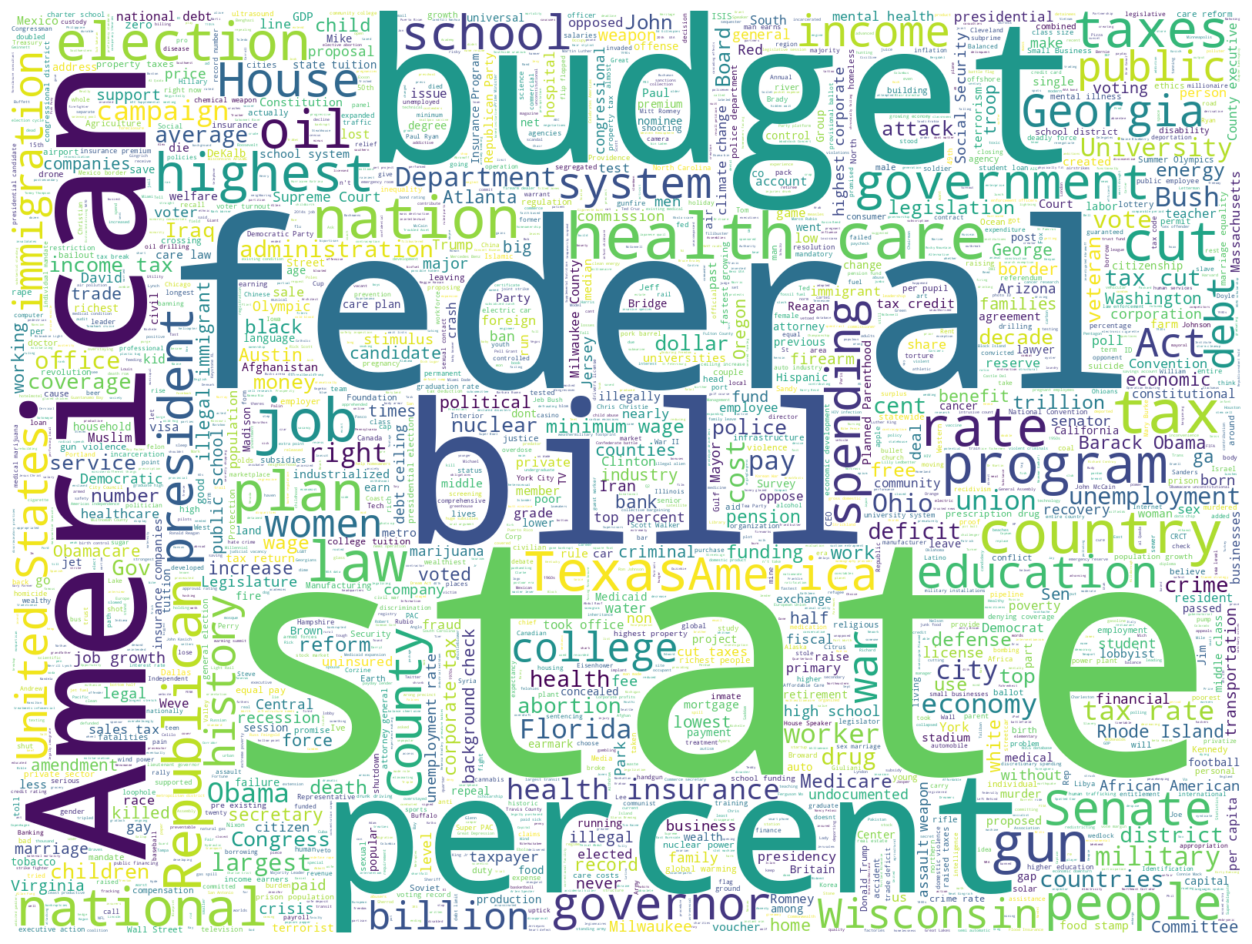

In [39]:
textt = " ".join(word_tokenize(" ".join(real_data.entities)))
print(len(textt.split()))
real_data_freq = generate_word_cloud(textt, stopwordss)


16774


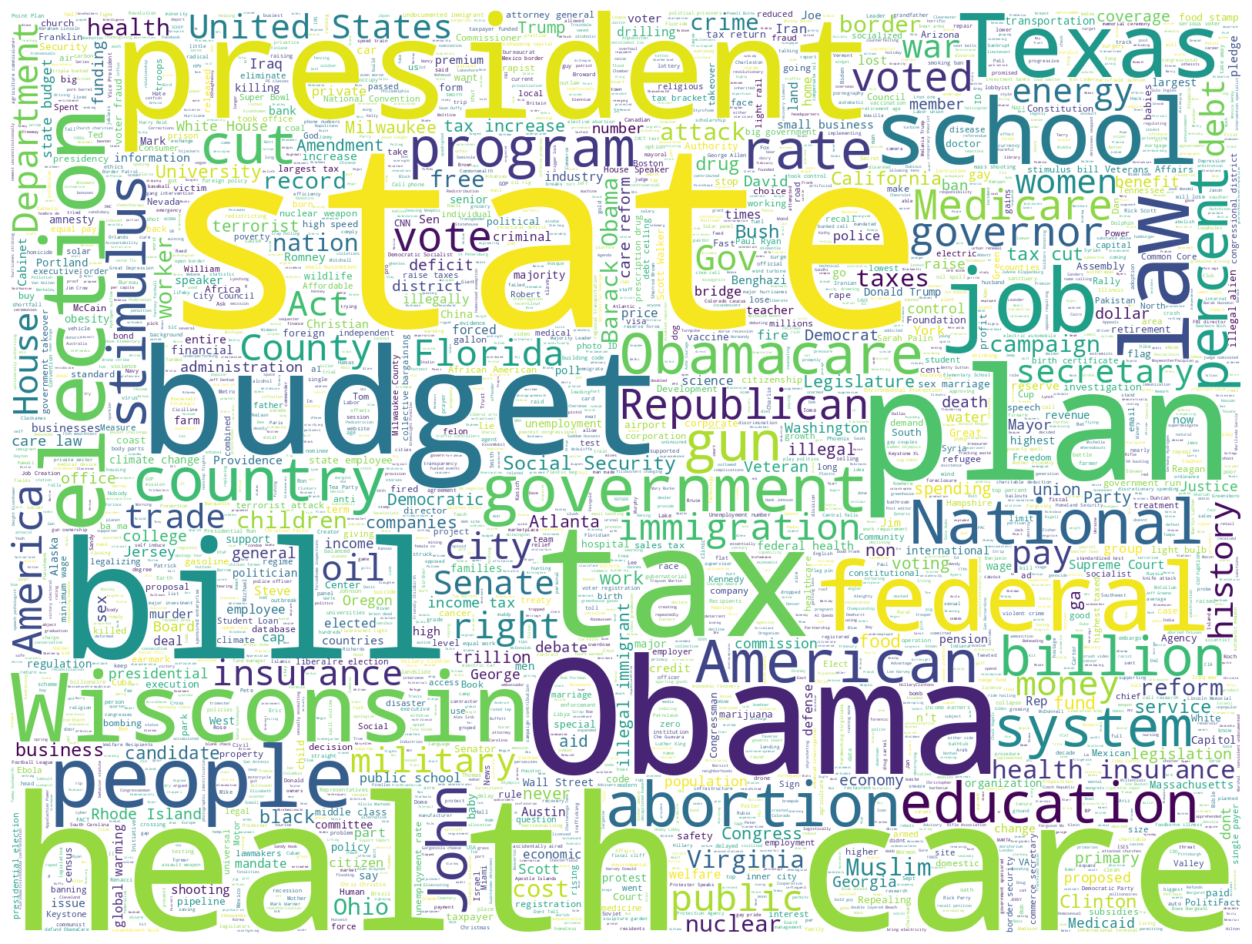

In [40]:
textt = " ".join(word_tokenize(" ".join(fake_data.entities)))
print(len(textt.split()))
# textt = "".join(similar_real_data.entities)
fake_data_freq = generate_word_cloud(textt, stopwordss)

In [41]:
req_freq = 0.25

In [42]:
a = [k for k, v in sorted(fake_data_freq.items(), key=lambda item: item[1], reverse=True) if v >= req_freq ] #and v <= 0.9]
a


['state',
 'health care',
 'bill',
 'Obama',
 'tax',
 'plan',
 'budget',
 'president',
 'Wisconsin',
 'law',
 'federal',
 'school',
 'Texas',
 'election',
 'job',
 'people',
 'government',
 'National',
 'abortion',
 'country',
 'American',
 'Obamacare',
 'education',
 'system',
 'gun',
 'John',
 'cut',
 'rate',
 'percent',
 'program',
 'billion',
 'stimulus',
 'Republican',
 'Medicare',
 'vote']

In [43]:
b = [k for k, v in sorted(real_data_freq.items(), key=lambda item: item[1], reverse=True) if v >= req_freq ]# and v <= 0.9]
b


['state',
 'federal',
 'budget',
 'bill',
 'percent',
 'American',
 'health care',
 'tax',
 'job',
 'country',
 'nation',
 'law']

In [44]:
set(a).intersection(set(b))

{'American',
 'bill',
 'budget',
 'country',
 'federal',
 'health care',
 'job',
 'law',
 'percent',
 'state',
 'tax'}

In [45]:
words_to_filter = set(list(set(a).intersection(set(b))) )# + a[:6] + b[:6])
words_to_filter

{'American',
 'bill',
 'budget',
 'country',
 'federal',
 'health care',
 'job',
 'law',
 'percent',
 'state',
 'tax'}

In [46]:
store_folder = "./LIAR_data/"
statements_file = "./statements.json"
data_filepath = loadFILE(store_folder+statements_file) 

In [47]:
fake_statements = data_filepath["fake"]
real_statements = data_filepath["real"]

In [48]:
similar_thres = int(input("Enter threshold value for similarity \nhow many common words needed to consider similar : "))
print(f"Threshold = {similar_thres}")

similar_fake_statements = [statement for statement in fake_statements if len(set(word_tokenize(statement)) & words_to_filter) > similar_thres]
similar_real_statements = [statement for statement in real_statements if len(set(word_tokenize(statement)) & words_to_filter) > similar_thres]


Threshold = 1


In [49]:
print(len(similar_fake_statements))
print(len(similar_real_statements))


197
330


In [50]:
similar_statements = {"fake" : similar_fake_statements, 
                      "real" : similar_real_statements}

NOW WE HAVE THE STATEMENTS WITH COMMON ENTITIES, \
THEY HAVE REAL/FAKE INFORMATION ON COMMON TOPICS

In [51]:
# STORING THE SIMILAR STATEMENTS FOR FURTHER PROCESSING

LIAR_similar_filename = "LIAR_similar_statements.json"

with open(LIAR_similar_filename, "w", encoding="utf-8") as json_f:
    json.dump(similar_statements, json_f, indent=3)

### ANALYSING THE NETWORK

In [31]:
liar_real_rslt_file = "./LIAR_similar_real_entites_330.p"
liar_fake_rslt_file = "./LIAR_similar_fake_entites_200.p"

In [32]:
fake_data = load_kb(liar_fake_rslt_file)
real_data = load_kb(liar_real_rslt_file)

In [25]:
def make_networkx(kg):
    G = nx.Graph()
    plt.figure(0,figsize=(20,20))

    # for e in kg.entities:
    #     G.add_node(e)
    #     # net.add_node(e, label=e, shape="dot", color=color_entity)

    labels = {}
    for r in kg.relations:
        G.add_edge(r['head'], r['tail'])
        labels[(r["head"], r["tail"])] = r["type"]

    scale=10 # Scaling the size of the nodes by 10*degree

    d = dict(G.degree)

    pos = nx.spring_layout(G)
    # pos = nx.kamada_kawai_layout(G)
    #Updating dict
    d.update((x, scale*y) for x, y in d.items())

    # nx.set_node_attributes(G,d,'size')
    # nx.set_edge_attributes(G,labels, 'labels')
    nx.draw_networkx_edge_labels(
                                G, pos,
                                edge_labels=labels,
                                font_color='red',
                                font_size=8
                                )
    nx.draw(G, cmap = plt.get_cmap('jet') )
    plt.show()
    return G


e:\Downloads\WeLearn\9th Sem\nineSemEnv\Lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


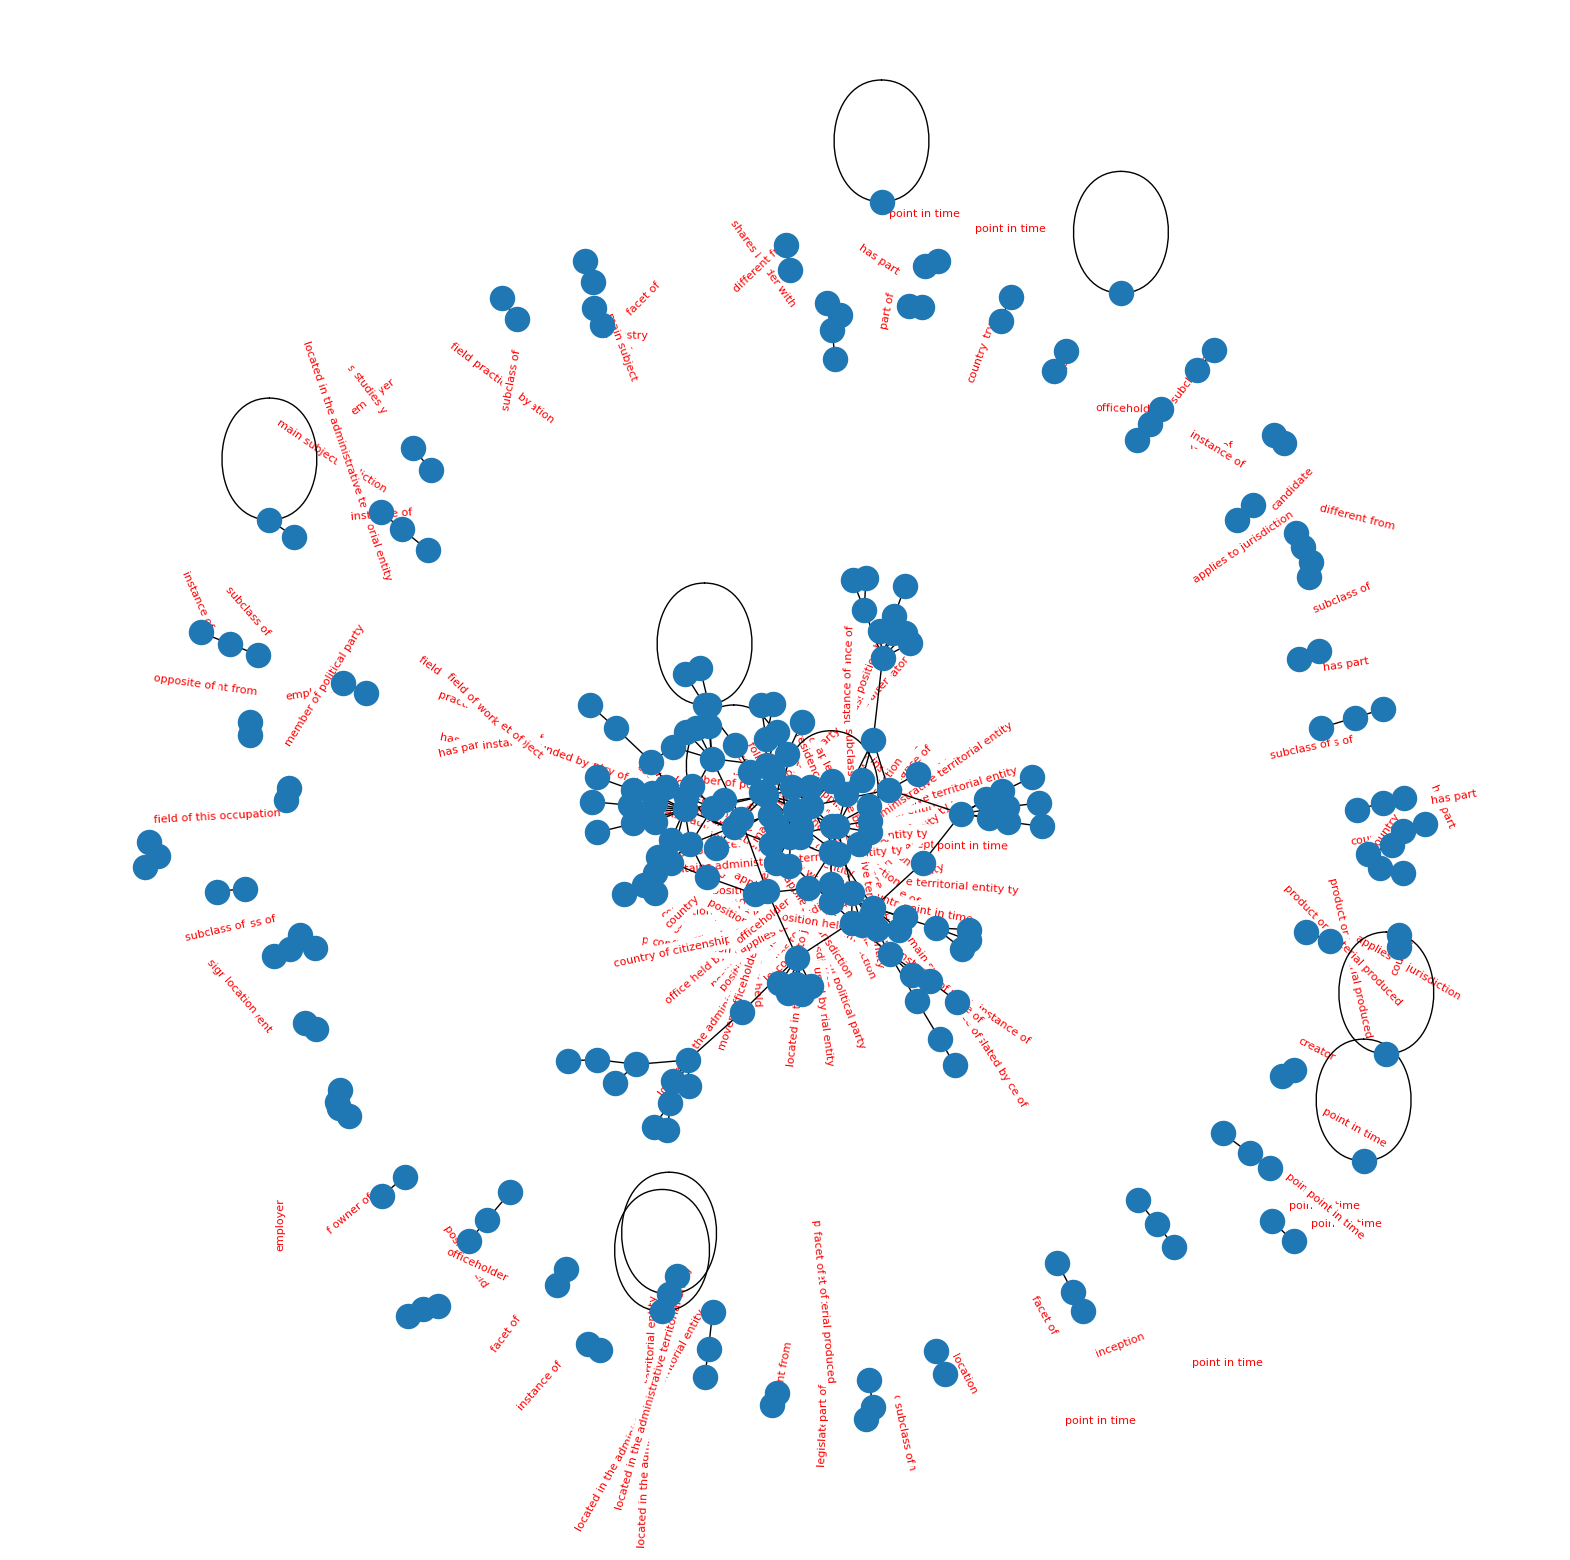

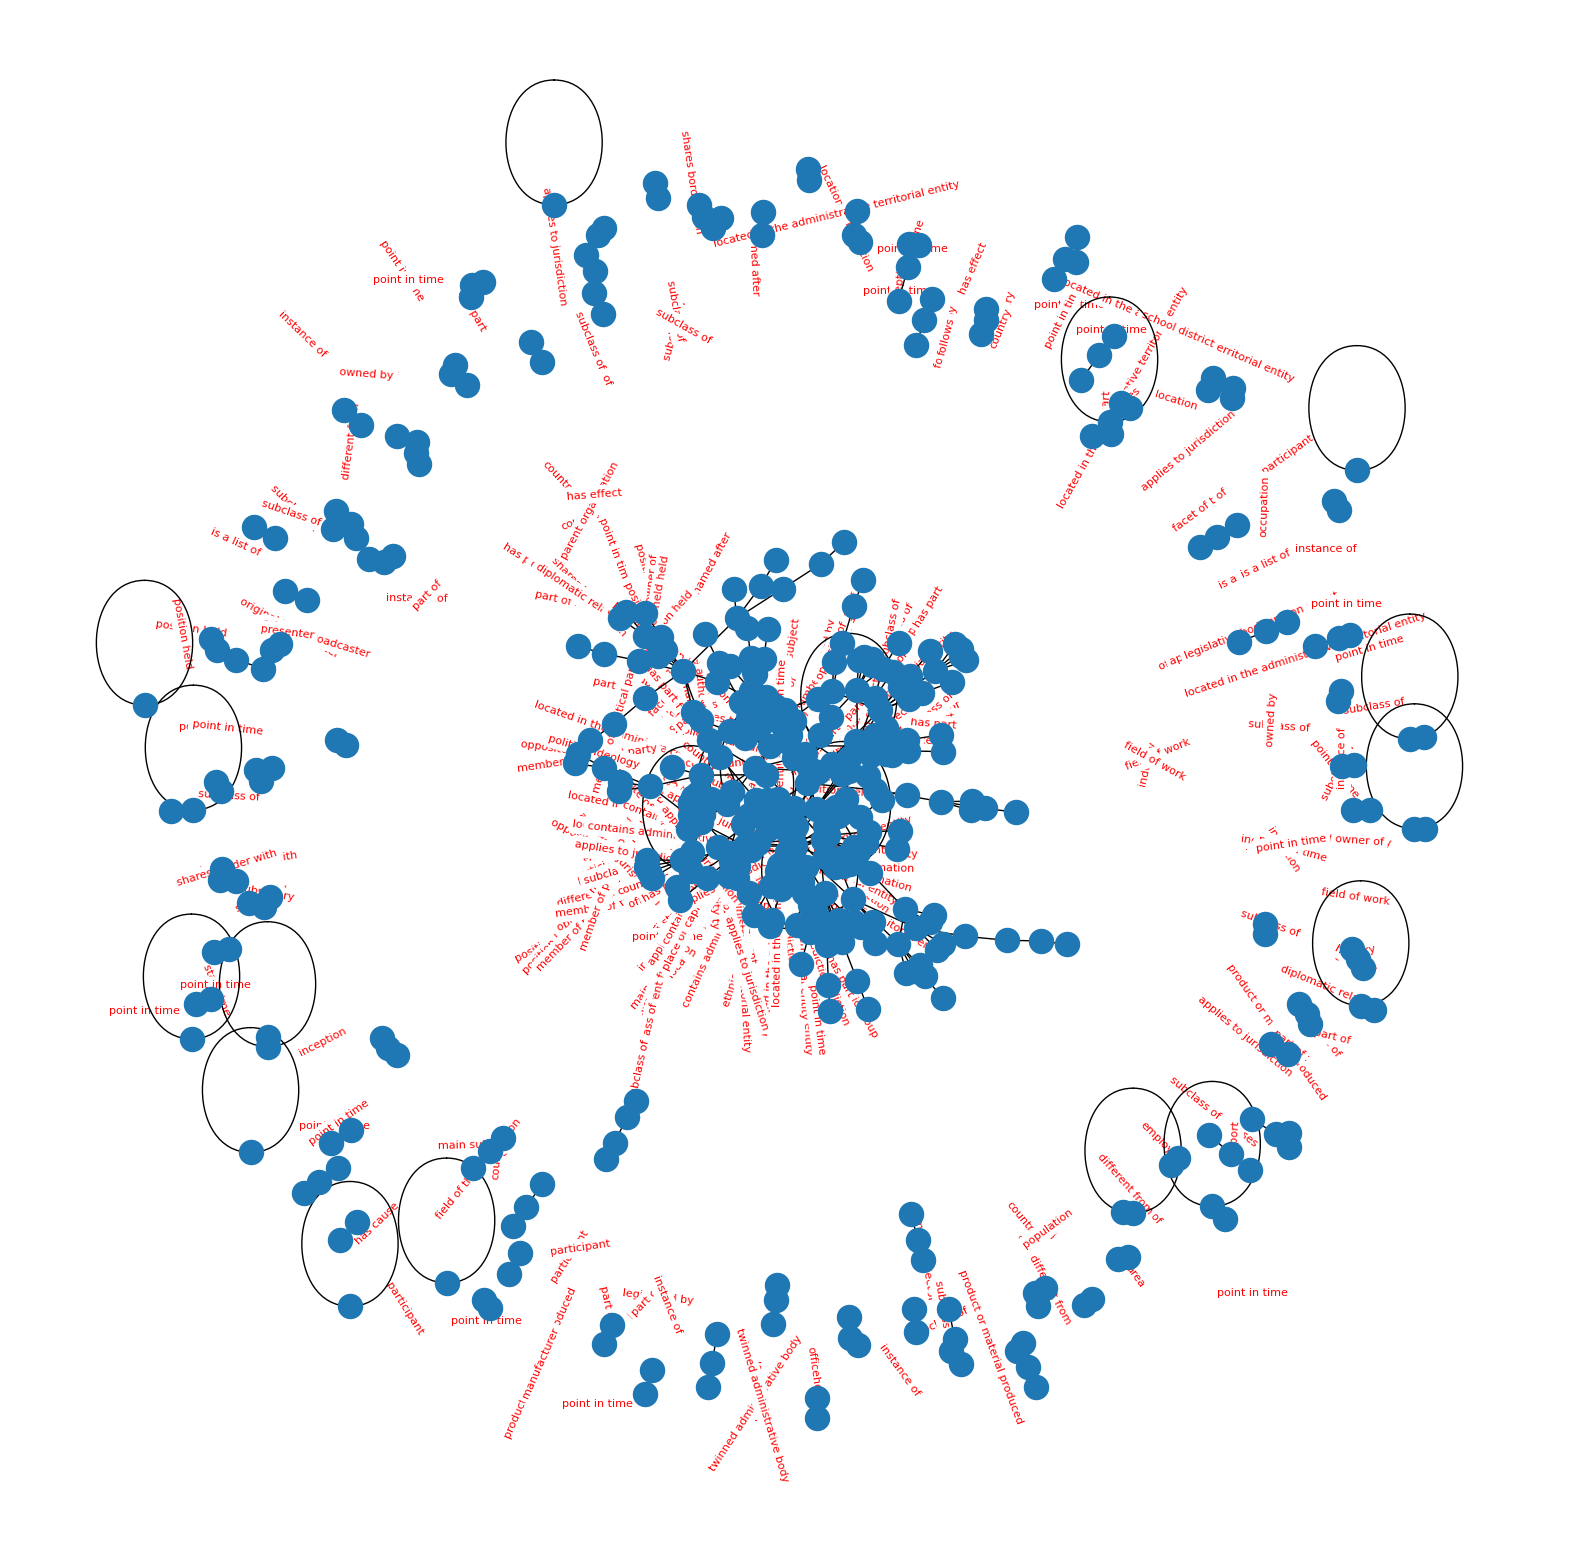

In [34]:
fake_graph = make_networkx(fake_data)
real_graph = make_networkx(real_data)

In [28]:
# import networkx as nx
# import matplotlib.pyplot as plt

def analyze_degree_distribution(G):
  """
  Analyzes the degree distribution of a NetworkX graph (undirected).

  Args:
      G: A NetworkX graph object.

  Returns:
      None
  """

  # Get the degree for each node
  degree_sequence = dict(G.degree())

  # Extract degrees and their counts
  degrees, counts = zip(*sorted(degree_sequence.items()))

  # Plot the degree distribution as a histogram
  plt.hist(counts, bins=20)

#   plt.bar(degrees, counts)
  plt.xlabel("Degree")
#   plt.xticks(rotation=90)
  plt.ylabel("# of Nodes")
#   plt.title("Degree Distribution of the Graph")
  plt.show()


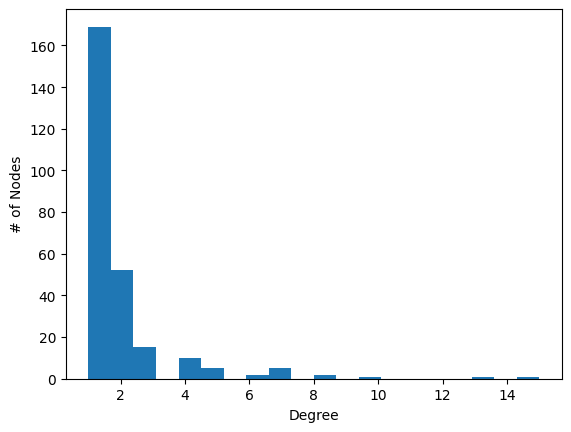

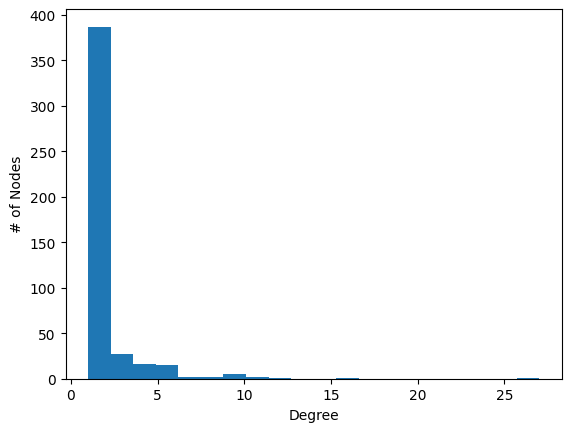

In [36]:
analyze_degree_distribution(fake_graph)
analyze_degree_distribution(real_graph)


In [37]:
ys = []
xs = []

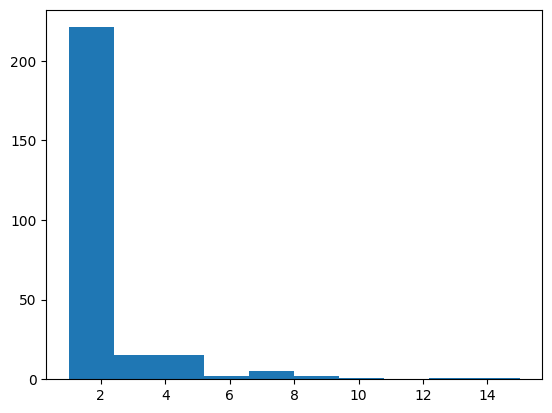

In [38]:
a, b = zip(*sorted(dict(fake_graph.degree()).items()))
_y, _x, _ = plt.hist(b)
_y, _x
ys.append(_y)
xs.append(_x)


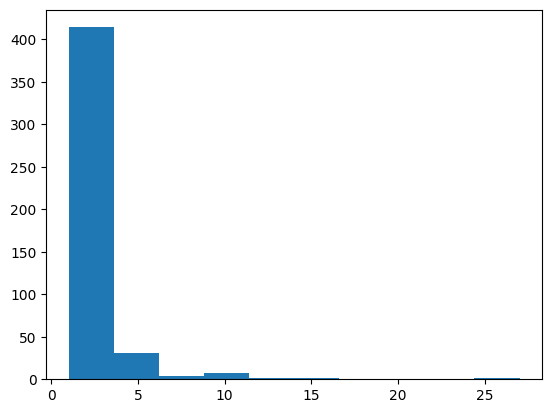

In [39]:
a, b = zip(*sorted(dict(real_graph.degree()).items()))
_y, _x, _ = plt.hist(b)
_y, _x
ys.append(_y)
xs.append(_x)


In [40]:
ys, xs

([array([221.,  15.,  15.,   2.,   5.,   2.,   1.,   0.,   1.,   1.]),
  array([414.,  31.,   4.,   7.,   1.,   1.,   0.,   0.,   0.,   1.])],
 [array([ 1. ,  2.4,  3.8,  5.2,  6.6,  8. ,  9.4, 10.8, 12.2, 13.6, 15. ]),
  array([ 1. ,  3.6,  6.2,  8.8, 11.4, 14. , 16.6, 19.2, 21.8, 24.4, 27. ])])

C:\Users\Happy\AppData\Local\Temp\ipykernel_19648\2106795412.py:34: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  height+0.1, f'{height:0.0f}'*(height > 0),


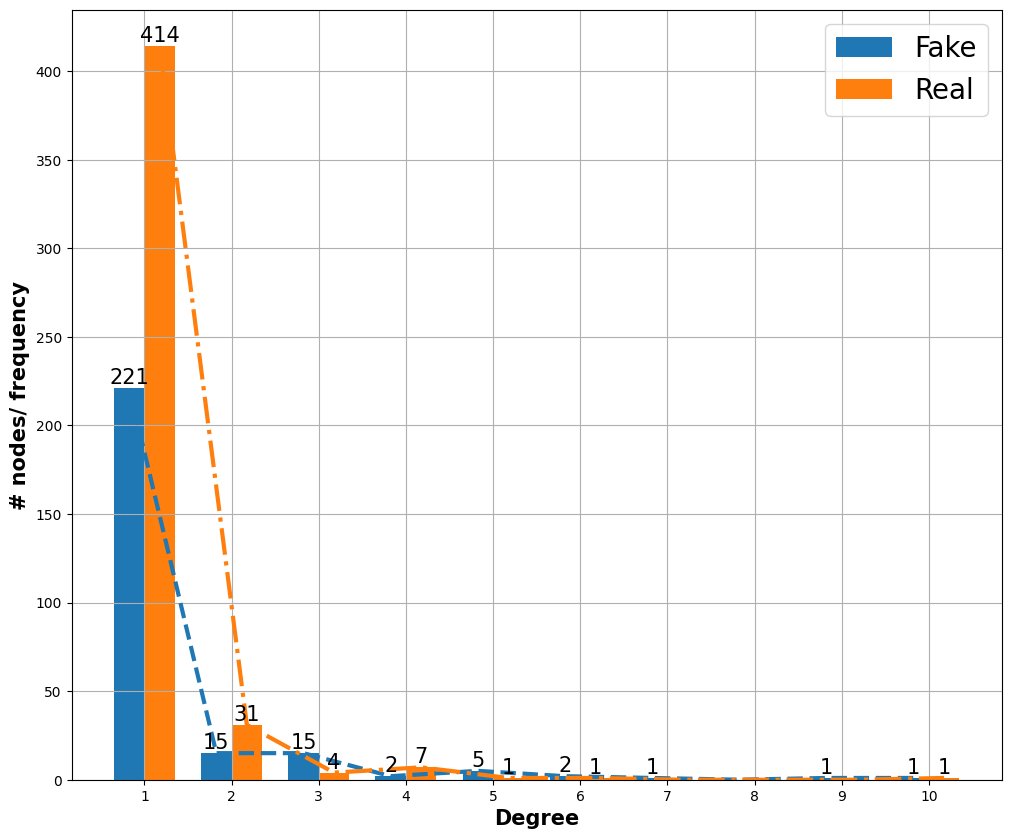

In [41]:
max_height = max([max(i) for i in ys])
barWidth = 0.35

fig = plt.subplots(figsize =(12, 10)) 

last_x = max([len(i) for i in xs])
br1 = np.arange(1, last_x)
# print(br1)
br2 = [x + barWidth for x in br1] 

bars1 = plt.bar(br1, ys[0], 
        width = barWidth, 
        label ='Fake') 

bars2 = plt.bar(br2, ys[1], 
        width = barWidth, 
        label ='Real') 

plt.plot(br1, ys[0], 
         "--",
         linewidth = 3)

plt.plot(br2, ys[1],
         "-.",
         linewidth = 3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        # if not height:
        #     continue
        # max_height = max(height, max_height)
        plt.text(bar.get_x() + bar.get_width() / 2, 
                 height+0.1, f'{height:0.0f}'*(height > 0), 
                 ha='center', 
                 va='bottom', 
                 rotation = 0,
                 size = 15)


# Adding Xticks 
plt.xlabel('Degree', fontweight ='bold', fontsize = 15) 
plt.ylabel('# nodes/ frequency', fontweight ='bold', fontsize = 15) 

plt.xticks([r + barWidth/2 for r in range(1, last_x)], 
        # [f'{_f} ({_i})' for _f, _i in zip(_full, labels)],rotation='vertical')
        [f'{_f}' for _f in range(1, last_x)])

plt.grid()

plt.legend( fontsize="20")
plt.show() 


C:\Users\Happy\AppData\Local\Temp\ipykernel_19648\4071264872.py:36: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  height+0.1, f'{height:0.0f}'*(height > 0),


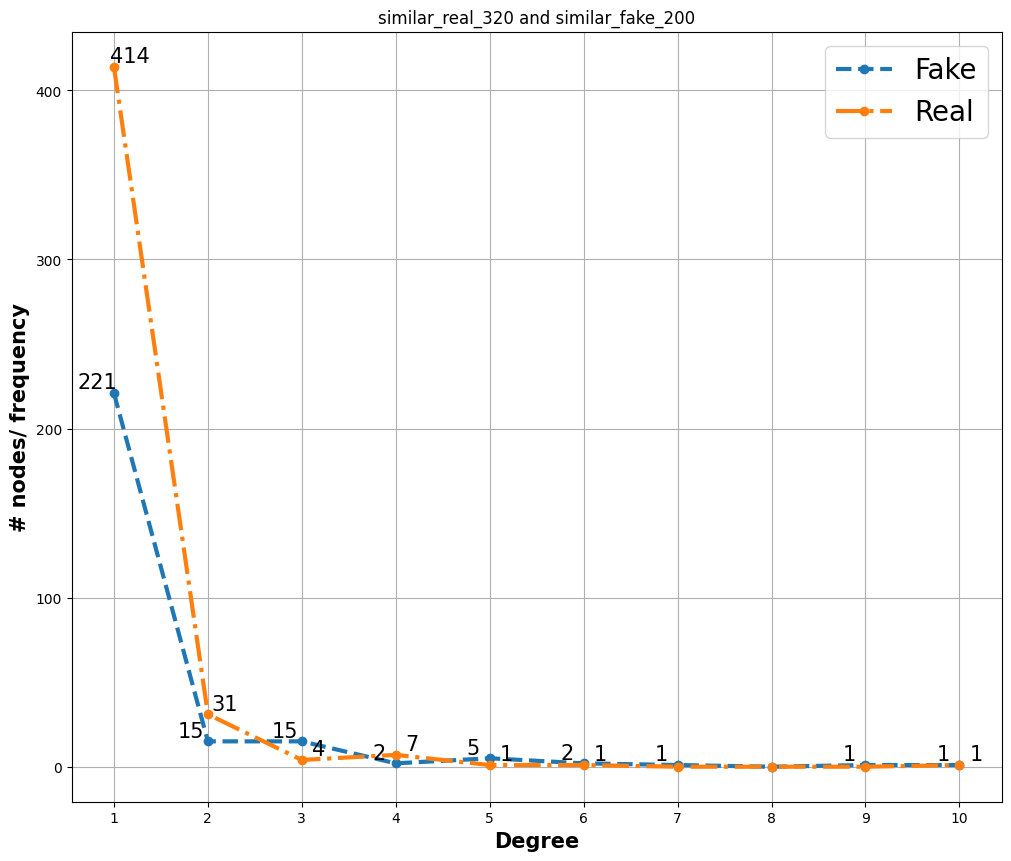

In [42]:
max_height = max([max(i) for i in ys])
barWidth = 0.35

fig = plt.subplots(figsize =(12, 10)) 

last_x = max([len(i) for i in xs])
br1 = np.arange(1, last_x)
# print(br1)
br2 = [x + barWidth for x in br1] 

# bars1 = plt.bar(br1, ys[0], 
#         width = barWidth, 
#         label ='Fake') 

# bars2 = plt.bar(br2, ys[1], 
#         width = barWidth, 
#         label ='Real') 

plt.plot(br1, ys[0], 
         "o--",
         linewidth = 3,
         label = "Fake")

plt.plot(br1, ys[1],
         "o-.",
         linewidth = 3,
         label = "Real")

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        # if not height:
        #     continue
        # max_height = max(height, max_height)
        plt.text(bar.get_x(), # + bar.get_width() / 2, 
                 height+0.1, f'{height:0.0f}'*(height > 0), 
                 ha='center', 
                 va='bottom', 
                 rotation = 0,
                 size = 15)


# Adding Xticks 
plt.xlabel('Degree', fontweight ='bold', fontsize = 15) 
plt.ylabel('# nodes/ frequency', fontweight ='bold', fontsize = 15) 

# plt.xticks([r + barWidth/2 for r in range(1, last_x)], 
#         # [f'{_f} ({_i})' for _f, _i in zip(_full, labels)],rotation='vertical')
#         [f'{_f}' for _f in range(1, last_x)])
plt.xticks([r for r in range(1, last_x)], 
        # [f'{_f} ({_i})' for _f, _i in zip(_full, labels)],rotation='vertical')
        [f'{_f}' for _f in range(1, last_x)])

plt.title("similar_real_320 and similar_fake_200")

plt.grid()
plt.legend( fontsize="20")
plt.show() 


C:\Users\Happy\AppData\Local\Temp\ipykernel_19648\1120203082.py:34: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  height+0.1, f'{height:0.0f}'*(height > 0),


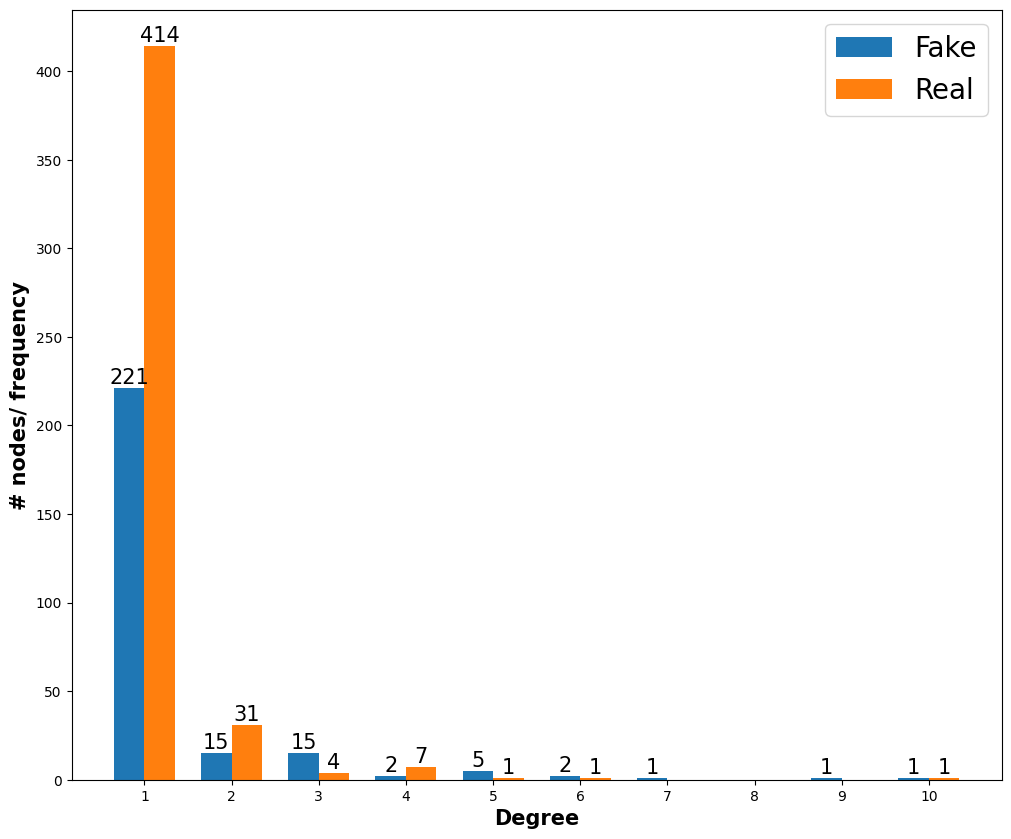

In [43]:
max_height = max([max(i) for i in ys])
barWidth = 0.35

fig = plt.subplots(figsize =(12, 10)) 

last_x = max([len(i) for i in xs])
br1 = np.arange(1, last_x)
# print(br1)
br2 = [x + barWidth for x in br1] 

bars1 = plt.bar(br1, ys[0], 
        width = barWidth, 
        label ='Fake') 

bars2 = plt.bar(br2, ys[1], 
        width = barWidth, 
        label ='Real') 

# plt.plot(br1, ys[0], 
#          "--",
#          linewidth = 3)

# plt.plot(br2, ys[1],
#          "-.",
#          linewidth = 3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        # if not height:
        #     continue
        # max_height = max(height, max_height)
        plt.text(bar.get_x() + bar.get_width() / 2, 
                 height+0.1, f'{height:0.0f}'*(height > 0), 
                 ha='center', 
                 va='bottom', 
                 rotation = 0,
                 size = 15)


# Adding Xticks 
plt.xlabel('Degree', fontweight ='bold', fontsize = 15) 
plt.ylabel('# nodes/ frequency', fontweight ='bold', fontsize = 15) 

plt.xticks([r + barWidth/2 for r in range(1, last_x)], 
        # [f'{_f} ({_i})' for _f, _i in zip(_full, labels)],rotation='vertical')
        [f'{_f}' for _f in range(1, last_x)])


plt.legend( fontsize="20")
plt.show() 


# FOR EQUAL STATEMENTS IN REAL AND FAKE DATASET

In [10]:
import random

In [11]:
statements_file = "./LIAR_similar_statements.json"

similar_statements = loadFILE(statements_file)

In [12]:
similar_statements_fake = similar_statements["fake"]
similar_statements_real = similar_statements["real"]

In [13]:

def equal_selections(list1, list2):
    min_len = min(len(list1), len(list2))
    return random.sample(list1, min_len), random.sample(list2, min_len)

In [14]:
len(similar_statements_fake), len(similar_statements_real)

(197, 330)

In [15]:
real_statements, fake_statements = equal_selections(similar_statements_real, similar_statements_fake)

In [16]:
liar_real_rslt_file = "./LIAR_similar_real_entites_330.p"
liar_fake_rslt_file = "./LIAR_similar_fake_entites_200.p"

fake_data = load_kb(liar_fake_rslt_file)
real_data = load_kb(liar_real_rslt_file)

In [17]:
len(fake_data.relations), len(real_data.relations)

(350, 601)

In [52]:
real_data.print()

Entities:
  ('Florida', {'url': 'https://en.wikipedia.org/wiki/Florida', 'summary': "Florida is a state in the Southeastern region of the United States. It borders the Gulf of Mexico to the west, Alabama to the northwest, Georgia to the north, the Bahamas and Atlantic Ocean to the east; and the Straits of Florida and Cuba to the south. It is the only state that borders both the Gulf of Mexico and the Atlantic Ocean. With a population over 21 million, it is the third-most populous state in the nation and ranks eighth in population density as of 2020. It spans , ranking 22nd in area among the 50 states. The Miami metropolitan area, anchored by the cities of Miami, Fort Lauderdale, and West Palm Beach, is the state's largest metropolitan area with a population of 6.138 million, and the state's most-populous city is Jacksonville with a population of 949,611. Florida's other major population centers include Tampa Bay, Orlando, Cape Coral, and the state capital of Tallahassee.\nVarious Ameri

In [18]:
kb_real_350 = KB()

In [19]:
kb_real_350.entities = real_data.entities 

In [20]:
kb_real_350.relations = real_data.relations[:len(fake_data.relations)]

In [72]:
kb_real_350.print()

Entities:
  ('Florida', {'url': 'https://en.wikipedia.org/wiki/Florida', 'summary': "Florida is a state in the Southeastern region of the United States. It borders the Gulf of Mexico to the west, Alabama to the northwest, Georgia to the north, the Bahamas and Atlantic Ocean to the east; and the Straits of Florida and Cuba to the south. It is the only state that borders both the Gulf of Mexico and the Atlantic Ocean. With a population over 21 million, it is the third-most populous state in the nation and ranks eighth in population density as of 2020. It spans , ranking 22nd in area among the 50 states. The Miami metropolitan area, anchored by the cities of Miami, Fort Lauderdale, and West Palm Beach, is the state's largest metropolitan area with a population of 6.138 million, and the state's most-populous city is Jacksonville with a population of 949,611. Florida's other major population centers include Tampa Bay, Orlando, Cape Coral, and the state capital of Tallahassee.\nVarious Ameri

In [21]:
entt_set = set()
for relation in kb_real_350.relations:
    entt_set.add(relation["head"])
    entt_set.add(relation["tail"])

In [74]:
entt_set

{'1',
 '100',
 '100 percent',
 '12',
 '1913',
 '1950',
 '1950s',
 '1960',
 '1960s',
 '1963',
 '1980',
 '1993',
 '1994',
 '2000',
 '2002',
 '2009',
 '2010',
 '2012',
 '2012 elections',
 '3rd grade',
 '40',
 '49th',
 'A law',
 'Abortion',
 'Abortions',
 'African-American',
 'Agencies',
 'Almond',
 'America',
 'American',
 'American citizens',
 'American healthcare system',
 'American people',
 'Americans',
 'Andrew Jackson',
 'Arizona',
 'Arizona Immigration Law',
 'Arizona immigration law',
 'Assassinated',
 'Assault Weapon',
 'Assault Weapons',
 'Assembly',
 'Baby formula',
 'Barack Obama',
 "Barack Obama's",
 'Barbara Buono',
 'Benefit',
 'Benefits',
 'Bermuda',
 'Bill',
 'Black males',
 'Born alive',
 'Broward',
 'Broward County',
 'Budget',
 'Budget Bill',
 'Bullet',
 'Bullets',
 'Bush tax cuts',
 'Business',
 'Canada',
 'Capital Investment',
 'Census',
 'Central',
 'Central America',
 'Central Texas',
 'Charges',
 'Charter School',
 'Charter Schools',
 'Cheese',
 'Cheesemakers',
 '

In [22]:
entt_obj = {}
for entt in real_data.entities:
    print(entt, real_data.entities[entt])
    if entt in entt_set:
        entt_obj[entt] = real_data.entities[entt]

Florida {'url': 'https://en.wikipedia.org/wiki/Florida', 'summary': "Florida is a state in the Southeastern region of the United States. It borders the Gulf of Mexico to the west, Alabama to the northwest, Georgia to the north, the Bahamas and Atlantic Ocean to the east; and the Straits of Florida and Cuba to the south. It is the only state that borders both the Gulf of Mexico and the Atlantic Ocean. With a population over 21 million, it is the third-most populous state in the nation and ranks eighth in population density as of 2020. It spans , ranking 22nd in area among the 50 states. The Miami metropolitan area, anchored by the cities of Miami, Fort Lauderdale, and West Palm Beach, is the state's largest metropolitan area with a population of 6.138 million, and the state's most-populous city is Jacksonville with a population of 949,611. Florida's other major population centers include Tampa Bay, Orlando, Cape Coral, and the state capital of Tallahassee.\nVarious American Indian tribe

In [76]:
entt_obj

{'Florida': {'url': 'https://en.wikipedia.org/wiki/Florida',
  'summary': "Florida is a state in the Southeastern region of the United States. It borders the Gulf of Mexico to the west, Alabama to the northwest, Georgia to the north, the Bahamas and Atlantic Ocean to the east; and the Straits of Florida and Cuba to the south. It is the only state that borders both the Gulf of Mexico and the Atlantic Ocean. With a population over 21 million, it is the third-most populous state in the nation and ranks eighth in population density as of 2020. It spans , ranking 22nd in area among the 50 states. The Miami metropolitan area, anchored by the cities of Miami, Fort Lauderdale, and West Palm Beach, is the state's largest metropolitan area with a population of 6.138 million, and the state's most-populous city is Jacksonville with a population of 949,611. Florida's other major population centers include Tampa Bay, Orlando, Cape Coral, and the state capital of Tallahassee.\nVarious American Indian

In [23]:
kb_real_350.entities = entt_obj

In [78]:
kb_real_350.print()

Entities:
  ('Florida', {'url': 'https://en.wikipedia.org/wiki/Florida', 'summary': "Florida is a state in the Southeastern region of the United States. It borders the Gulf of Mexico to the west, Alabama to the northwest, Georgia to the north, the Bahamas and Atlantic Ocean to the east; and the Straits of Florida and Cuba to the south. It is the only state that borders both the Gulf of Mexico and the Atlantic Ocean. With a population over 21 million, it is the third-most populous state in the nation and ranks eighth in population density as of 2020. It spans , ranking 22nd in area among the 50 states. The Miami metropolitan area, anchored by the cities of Miami, Fort Lauderdale, and West Palm Beach, is the state's largest metropolitan area with a population of 6.138 million, and the state's most-populous city is Jacksonville with a population of 949,611. Florida's other major population centers include Tampa Bay, Orlando, Cape Coral, and the state capital of Tallahassee.\nVarious Ameri

In [79]:
filename = f"LIAR_similar_real_entites_350.html"

save_network_html(kb_real_350, filename=filename, verbose=True)
save_kb(kb_real_350, os.path.basename(filename)[:-5]  + ".p")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
Network initialized
there are 297 entities in KB
there are 350 relations in KB
Trying to make graph
Trying to show graph


### NETWORK ANALYSIS 

e:\Downloads\WeLearn\9th Sem\nineSemEnv\Lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


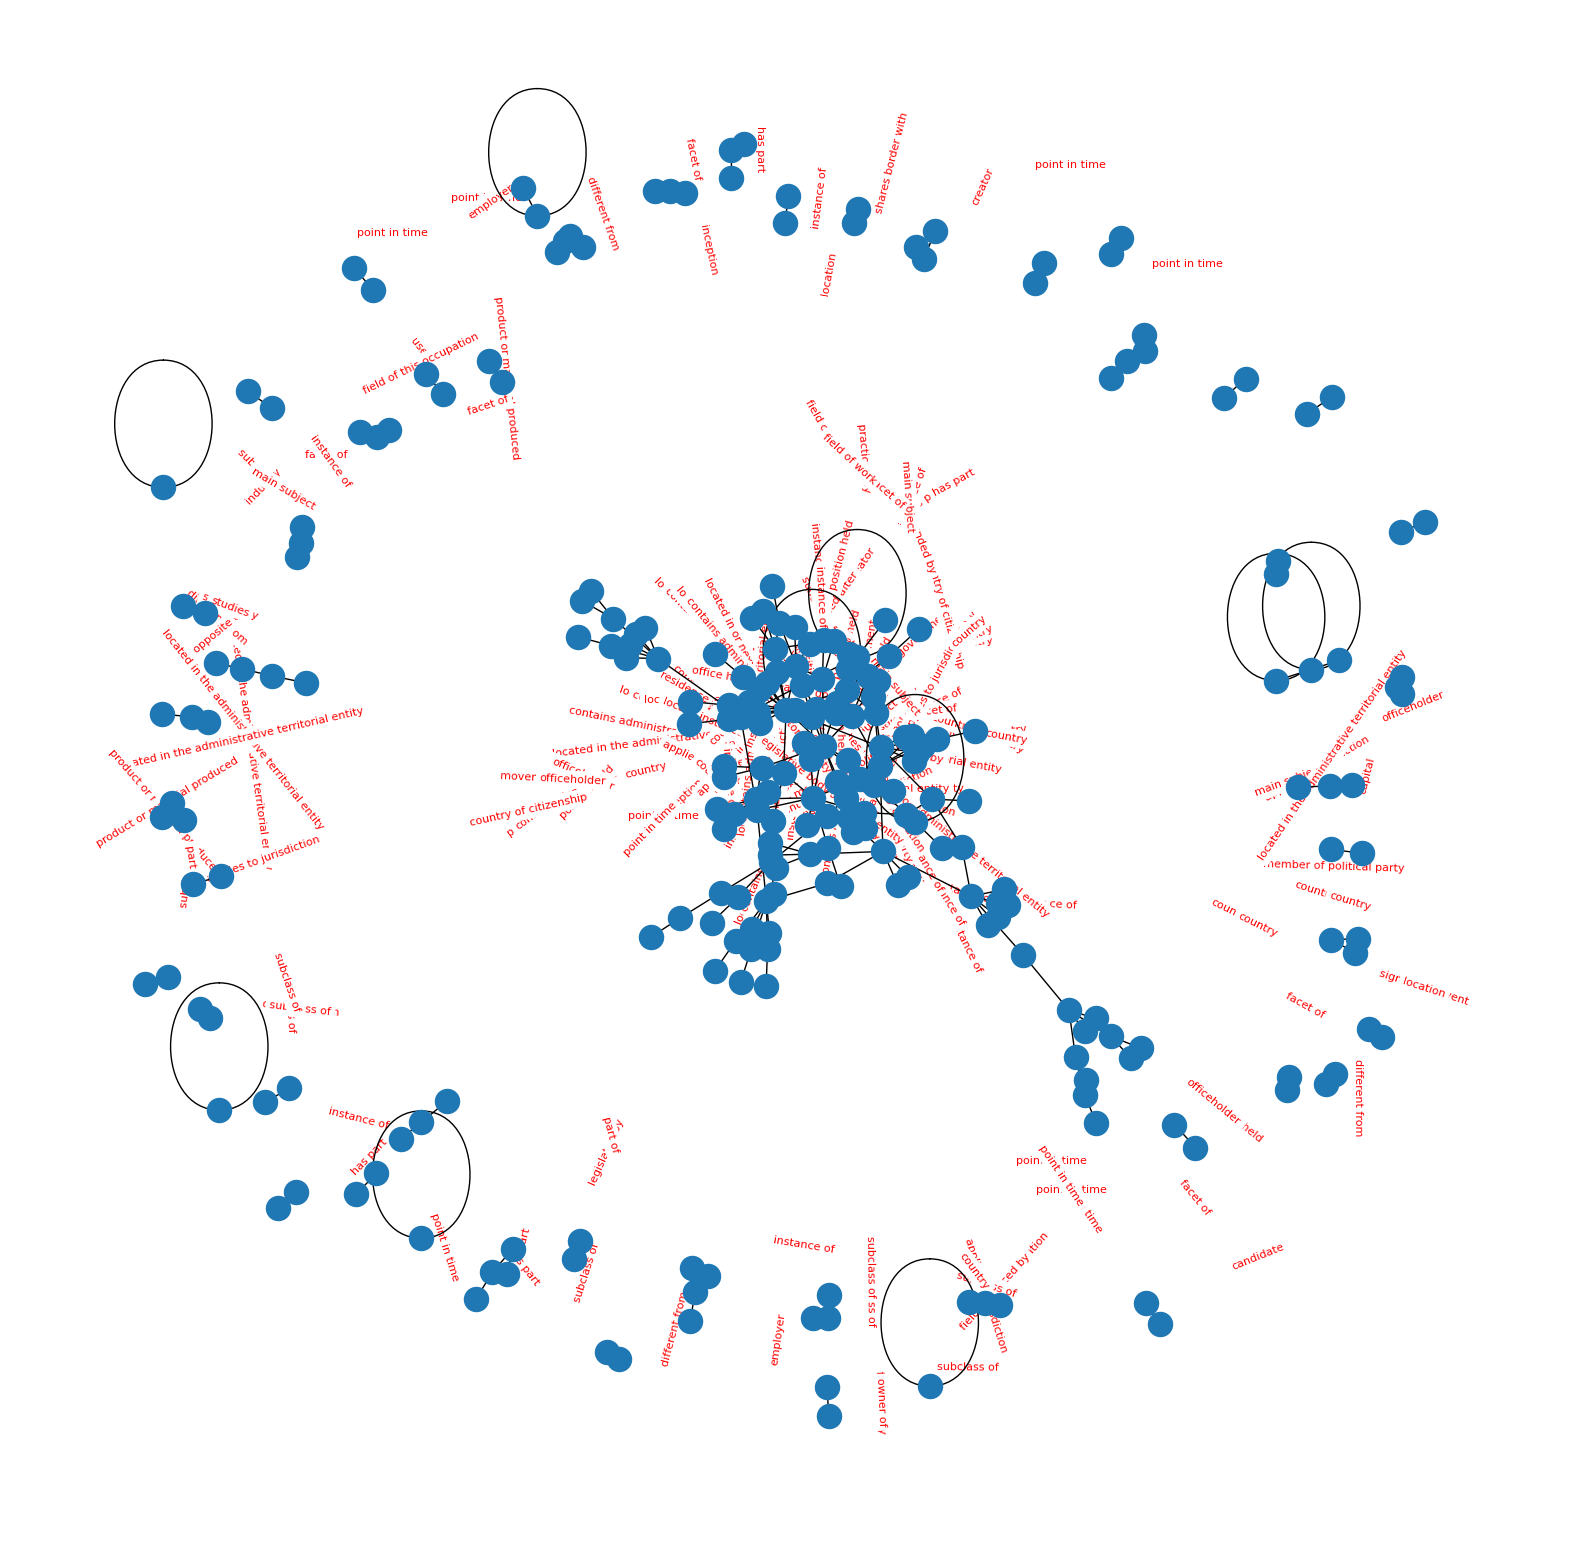

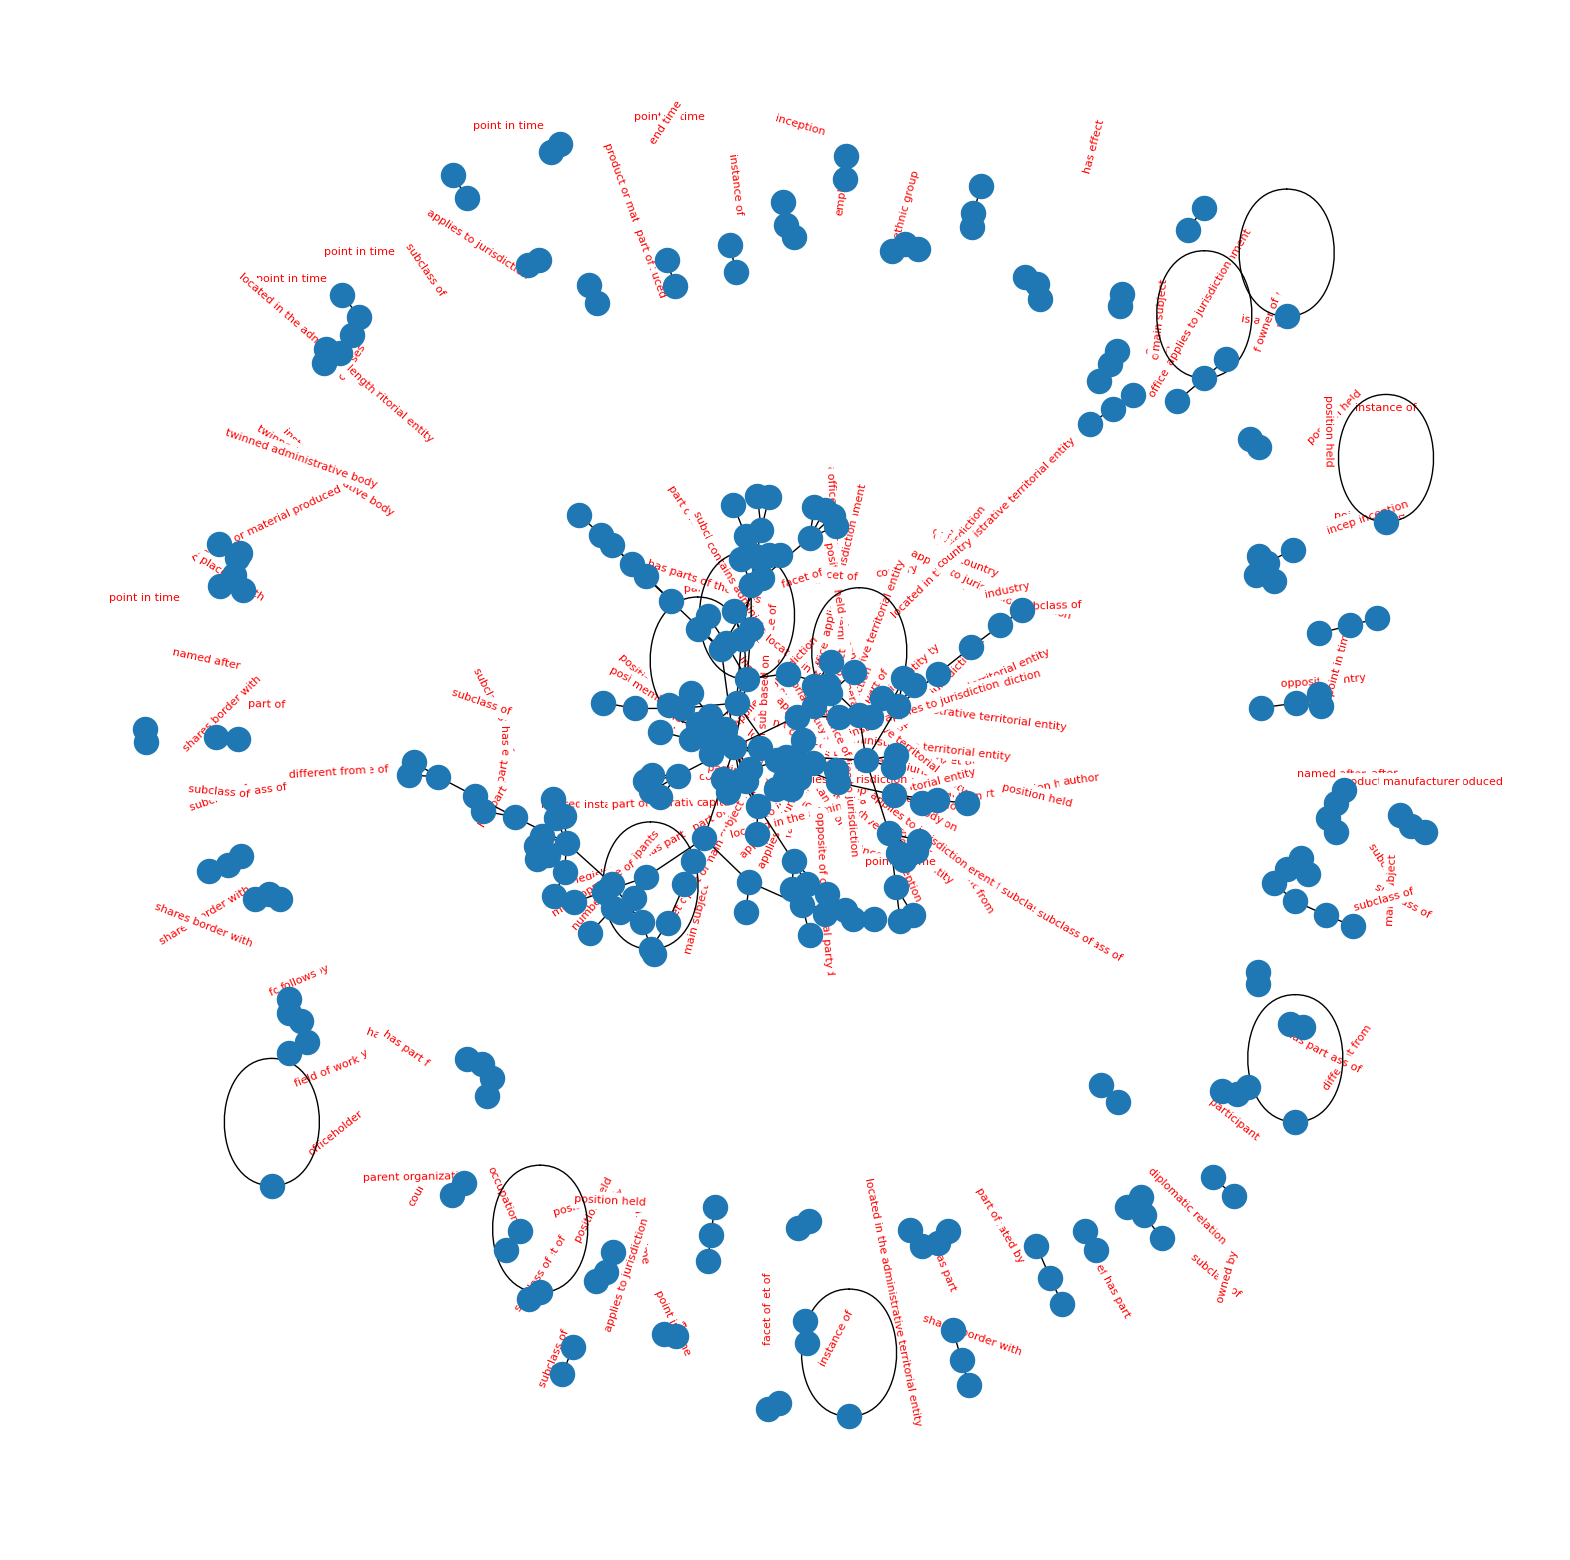

In [26]:
fake_graph = make_networkx(fake_data)
real_graph = make_networkx(kb_real_350)

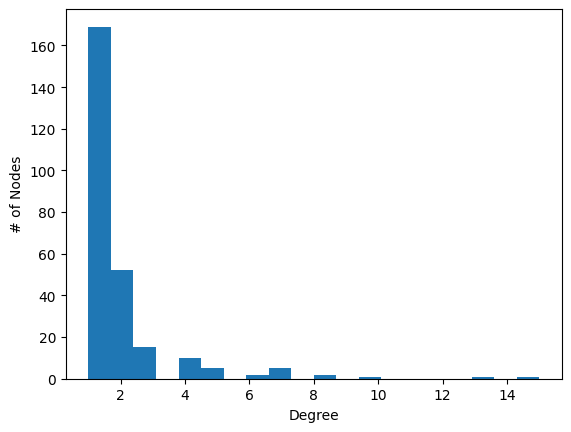

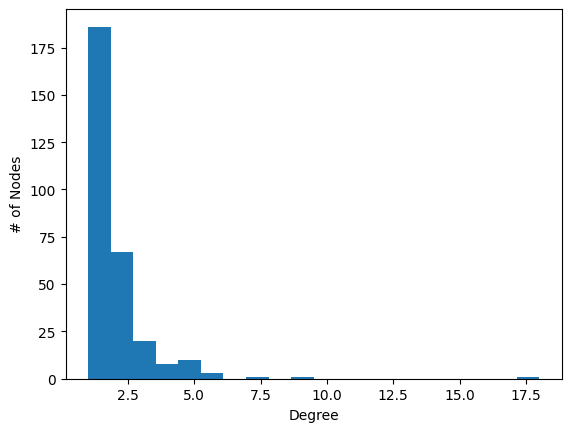

In [29]:
analyze_degree_distribution(fake_graph)
analyze_degree_distribution(real_graph)


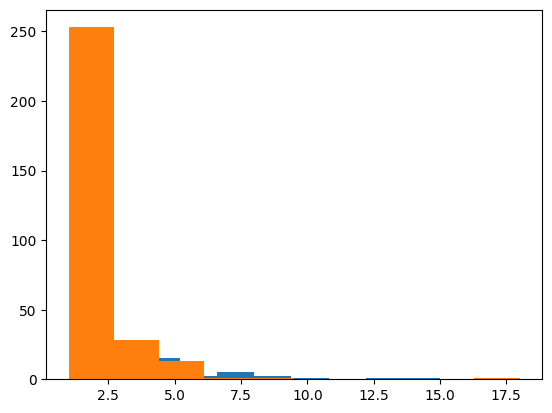

In [30]:
ys = []
xs = []

a, b = zip(*sorted(dict(fake_graph.degree()).items()))
_y, _x, _ = plt.hist(b)
_y, _x
ys.append(_y)
xs.append(_x)

a, b = zip(*sorted(dict(real_graph.degree()).items()))
_y, _x, _ = plt.hist(b)
_y, _x
ys.append(_y)
xs.append(_x)



C:\Users\Happy\AppData\Local\Temp\ipykernel_19136\4243599765.py:34: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  height+0.1, f'{height:0.0f}'*(height > 0),


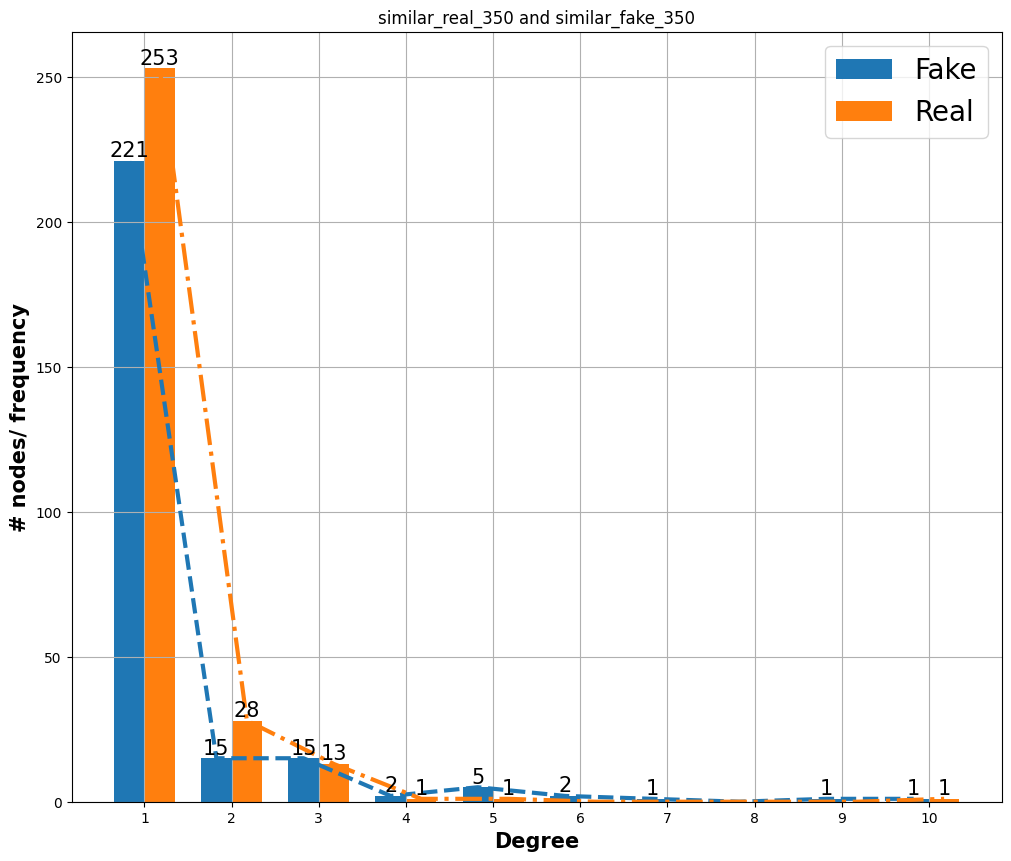

In [31]:
max_height = max([max(i) for i in ys])
barWidth = 0.35

fig = plt.subplots(figsize =(12, 10)) 

last_x = max([len(i) for i in xs])
br1 = np.arange(1, last_x)
# print(br1)
br2 = [x + barWidth for x in br1] 

bars1 = plt.bar(br1, ys[0], 
        width = barWidth, 
        label ='Fake') 

bars2 = plt.bar(br2, ys[1], 
        width = barWidth, 
        label ='Real') 

plt.plot(br1, ys[0], 
         "--",
         linewidth = 3)

plt.plot(br2, ys[1],
         "-.",
         linewidth = 3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        # if not height:
        #     continue
        # max_height = max(height, max_height)
        plt.text(bar.get_x() + bar.get_width() / 2, 
                 height+0.1, f'{height:0.0f}'*(height > 0), 
                 ha='center', 
                 va='bottom', 
                 rotation = 0,
                 size = 15)


# Adding Xticks 
plt.xlabel('Degree', fontweight ='bold', fontsize = 15) 
plt.ylabel('# nodes/ frequency', fontweight ='bold', fontsize = 15) 

plt.xticks([r + barWidth/2 for r in range(1, last_x)], 
        # [f'{_f} ({_i})' for _f, _i in zip(_full, labels)],rotation='vertical')
        [f'{_f}' for _f in range(1, last_x)])

plt.grid()
plt.title("similar_real_350 and similar_fake_350")
plt.legend( fontsize="20")
plt.show() 


C:\Users\Happy\AppData\Local\Temp\ipykernel_19136\2541693032.py:36: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  height+0.1, f'{height:0.0f}'*(height > 0),


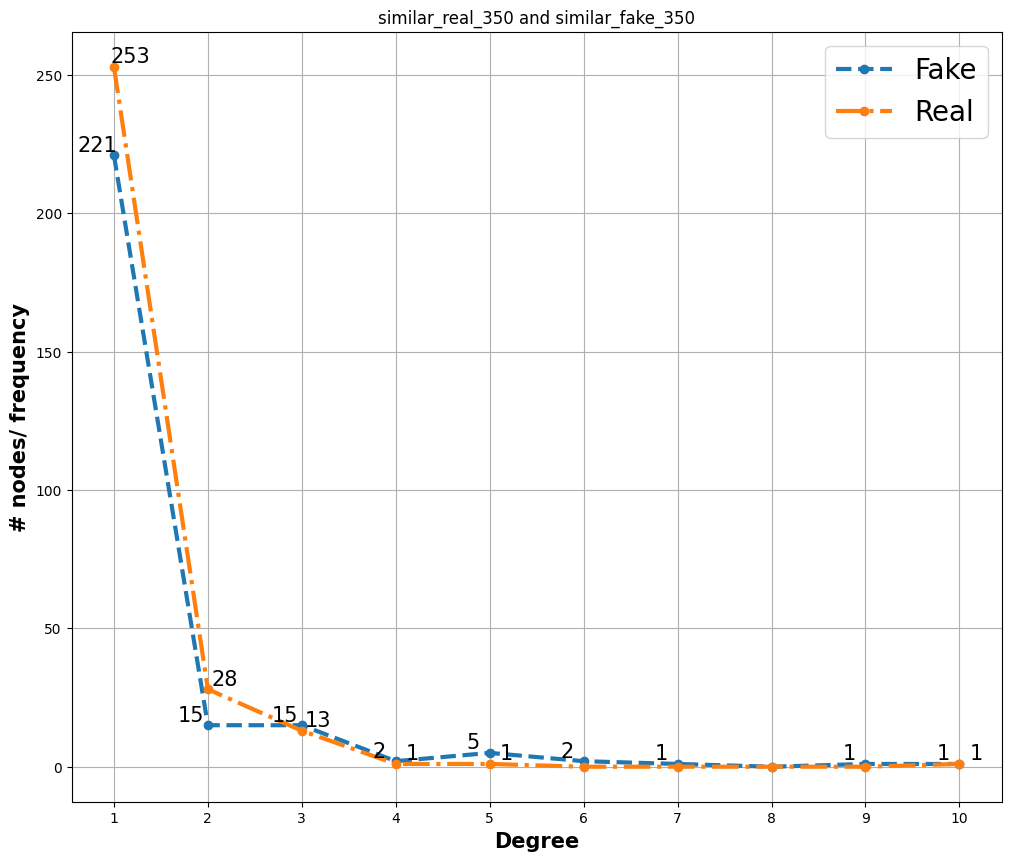

In [32]:
max_height = max([max(i) for i in ys])
barWidth = 0.35

fig = plt.subplots(figsize =(12, 10)) 

last_x = max([len(i) for i in xs])
br1 = np.arange(1, last_x)
# print(br1)
br2 = [x + barWidth for x in br1] 

# bars1 = plt.bar(br1, ys[0], 
#         width = barWidth, 
#         label ='Fake') 

# bars2 = plt.bar(br2, ys[1], 
#         width = barWidth, 
#         label ='Real') 

plt.plot(br1, ys[0], 
         "o--",
         linewidth = 3,
         label = "Fake")

plt.plot(br1, ys[1],
         "o-.",
         linewidth = 3,
         label="Real")

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        # if not height:
        #     continue
        # max_height = max(height, max_height)
        plt.text(bar.get_x(), # + bar.get_width() / 2, 
                 height+0.1, f'{height:0.0f}'*(height > 0), 
                 ha='center', 
                 va='bottom', 
                 rotation = 0,
                 size = 15)


# Adding Xticks 
plt.xlabel('Degree', fontweight ='bold', fontsize = 15) 
plt.ylabel('# nodes/ frequency', fontweight ='bold', fontsize = 15) 

# plt.xticks([r + barWidth/2 for r in range(1, last_x)], 
#         # [f'{_f} ({_i})' for _f, _i in zip(_full, labels)],rotation='vertical')
#         [f'{_f}' for _f in range(1, last_x)])
plt.xticks([r for r in range(1, last_x)], 
        # [f'{_f} ({_i})' for _f, _i in zip(_full, labels)],rotation='vertical')
        [f'{_f}' for _f in range(1, last_x)])


plt.title("similar_real_350 and similar_fake_350")
plt.grid()
plt.legend( fontsize="20")
plt.show() 


C:\Users\Happy\AppData\Local\Temp\ipykernel_19136\940841530.py:34: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  height+0.1, f'{height:0.0f}'*(height > 0),


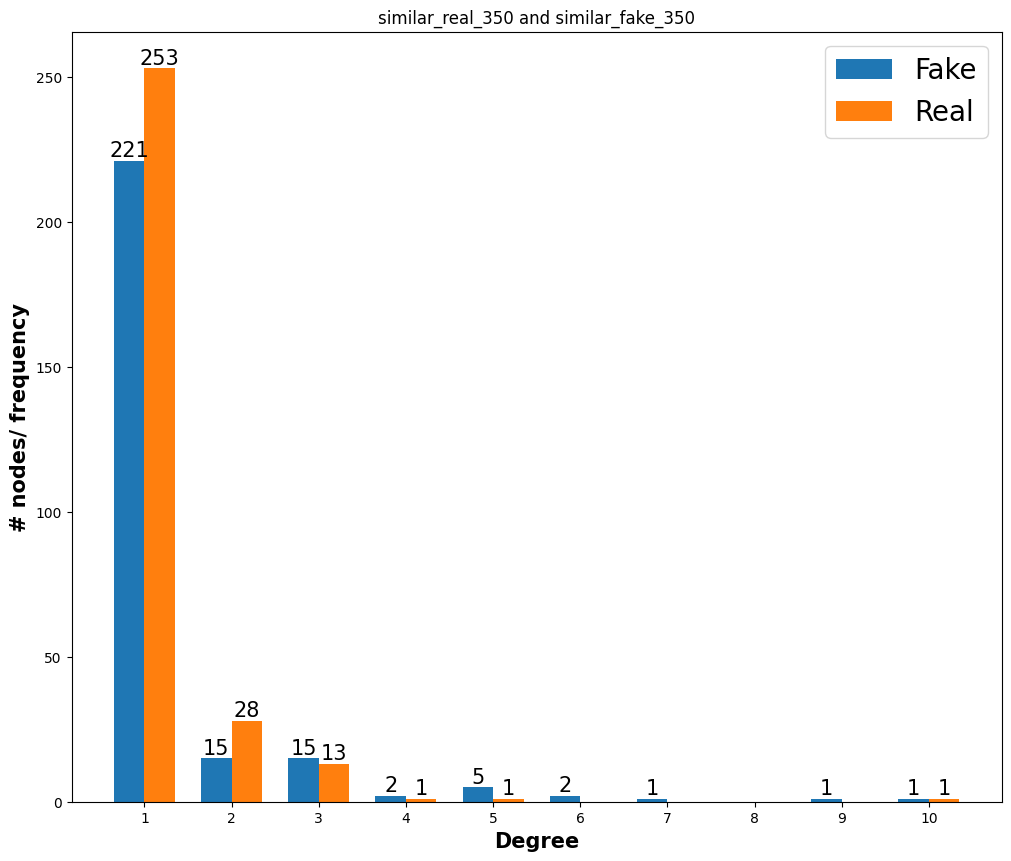

In [33]:
max_height = max([max(i) for i in ys])
barWidth = 0.35

fig = plt.subplots(figsize =(12, 10)) 

last_x = max([len(i) for i in xs])
br1 = np.arange(1, last_x)
# print(br1)
br2 = [x + barWidth for x in br1] 

bars1 = plt.bar(br1, ys[0], 
        width = barWidth, 
        label ='Fake') 

bars2 = plt.bar(br2, ys[1], 
        width = barWidth, 
        label ='Real') 

# plt.plot(br1, ys[0], 
#          "--",
#          linewidth = 3)

# plt.plot(br2, ys[1],
#          "-.",
#          linewidth = 3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        # if not height:
        #     continue
        # max_height = max(height, max_height)
        plt.text(bar.get_x() + bar.get_width() / 2, 
                 height+0.1, f'{height:0.0f}'*(height > 0), 
                 ha='center', 
                 va='bottom', 
                 rotation = 0,
                 size = 15)


# Adding Xticks 
plt.xlabel('Degree', fontweight ='bold', fontsize = 15) 
plt.ylabel('# nodes/ frequency', fontweight ='bold', fontsize = 15) 

plt.xticks([r + barWidth/2 for r in range(1, last_x)], 
        # [f'{_f} ({_i})' for _f, _i in zip(_full, labels)],rotation='vertical')
        [f'{_f}' for _f in range(1, last_x)])

plt.title("similar_real_350 and similar_fake_350")
plt.legend( fontsize="20")
plt.show() 


#### CHECKING LINK LENGTHS

In [121]:
def plot_link_length_histogram(graph):
    # Initialize a list to store the link lengths
    link_lengths = []
    barWidth = 0.5


    # Iterate through each node in the graph
    for node in graph.nodes():
        # Count the number of links for the current node
        link_lengths.append(len(list(graph.neighbors(node))))

    # Plot the histogram
    fig = plt.subplots(figsize =(12, 10)) 
    plt.hist(link_lengths, bins=range(max(link_lengths) + 2), edgecolor='black', alpha = 0.8, rwidth=barWidth)
    plt.xlabel('Link Length')
    plt.ylabel('Frequency')
    plt.title('Histogram of Link Lengths')
    plt.xticks([i+barWidth for i in range(1+max(link_lengths))], [f"{i}" for i in range(1+max(link_lengths))])
    plt.grid(True)
    plt.show()

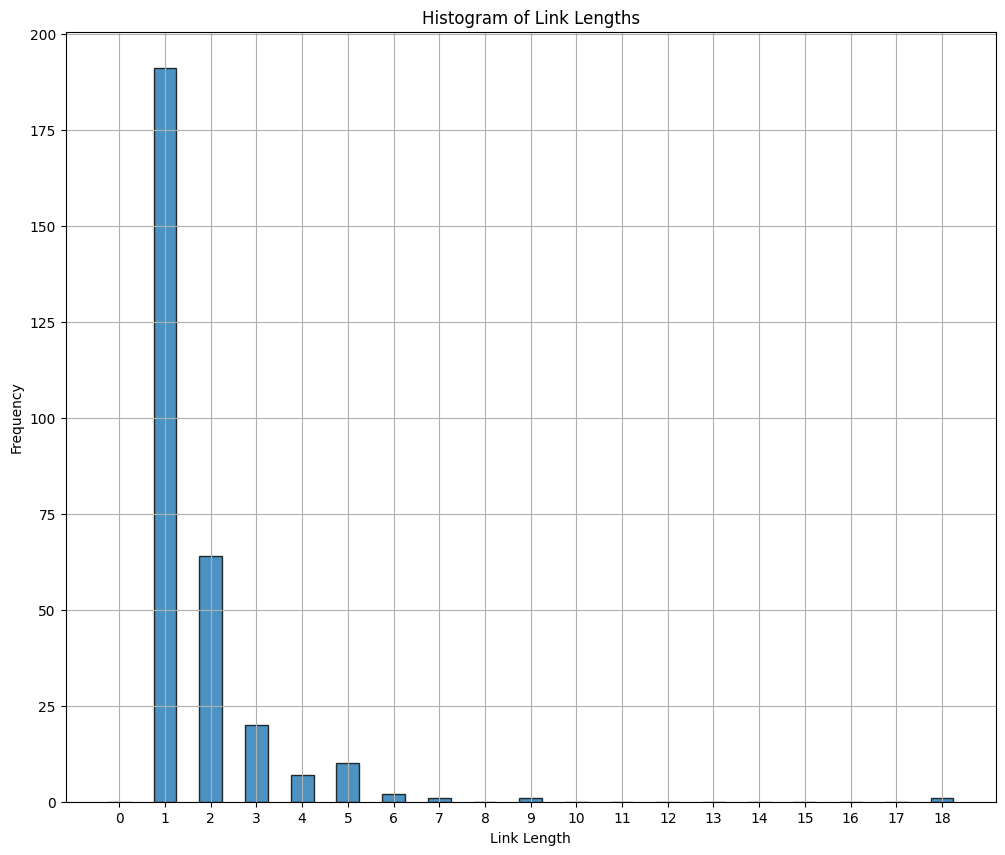

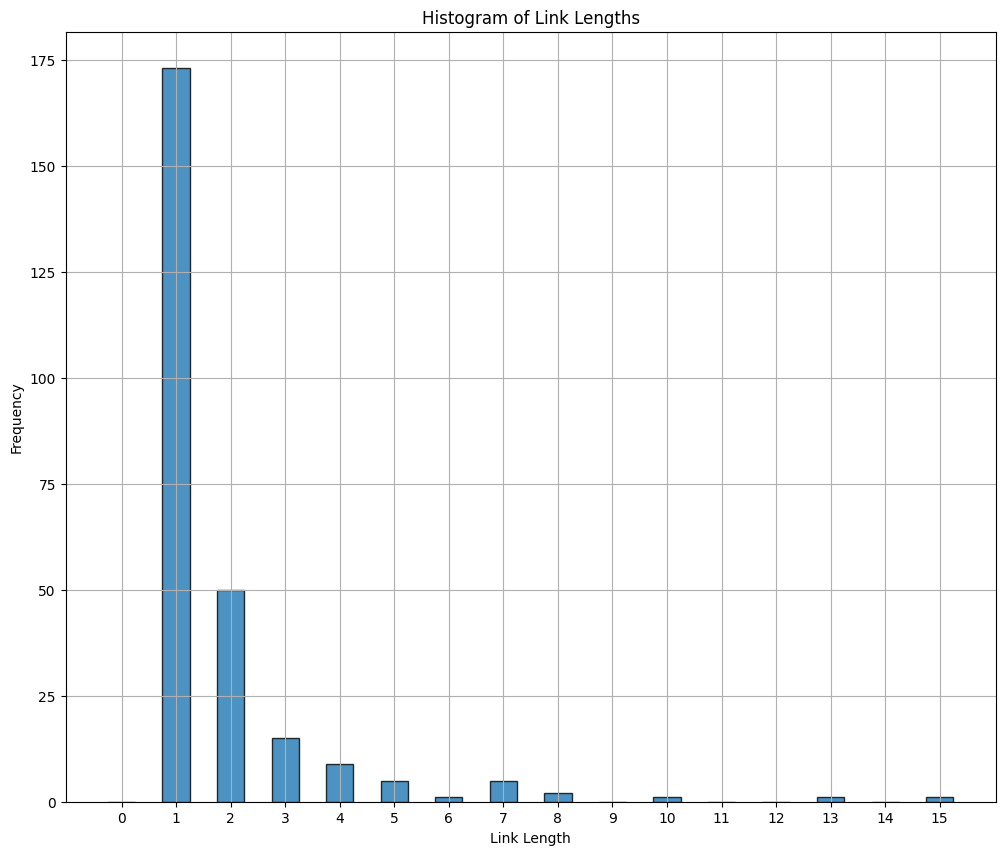

In [122]:
plot_link_length_histogram(real_graph)
plot_link_length_histogram(fake_graph)
